# Data Cleaning and Question Definition

#### Group Number: 13

#### Group Members:
- Pranav Bhardwaj
- Sarah Nance
- Sebastian Dodt

#### Presentation Video
https://youtu.be/ESuvnt-flkM

# Outline

1. Data Cleaning
2. Data Merging
3. Descriptive Analysis
4. Definition of `X` and `y`
5. Linear Models
6. GAMs
7. Ridge and Lasso
8. Random Forest Regressor
9. Model Selection and Conclusions
10. Discussion
11. References


# Introduction

In this project we are aiming to explore the relationship between pollution and health issues, in particular, lung cancer and strokes. 

For this purpose we have collected various pollution metrics and case incidences for lung cancer and strokes as well as control variables that also affect health outcomes, e.g., pre-existing conditions (diabetes, obesity), behavioural metrics (alcohol consumption), and outside influences (asbestos and radon prevalence).

In a final segment, we will take a step back and analyse the connection between pollution and socio-economic/demographic variables.  

## Research objectives

#### Question 1: Are there more strokes in counties with high pollution? 
For this question, we are using datasets `X1` and `y1` which include the most significant predictors for strokes including pollution. We hope that this may help us delineate the relationship that exists between pollution and strokes.

#### Question 2: Is there a higher lung cancer incidence in counties with high pollution?
For this question, we are using datasets `X2` and `y2` which include the most significant predictors for lung cancer and also includes pollution. We hope that this may help us delineate the relationship that exists between pollution and lung cancer.

#### Question 3: Are marginalised demographics more likely to live in counties with high pollution? 
For this question, we are using datasets `X3` and `y3` which include demographic variables (race, ethnicity) as well as socio-economic variables (income, poverty, unemployment) to deduce whether marginalised demographics are suffering more from polluted air.

# 1. Data Cleaning

- We have relatively few NAs. In section 1.1, we will deal with them individually for each dataset used.

- The final dataset to be used for our analysis contains observations for counties in most US states and is well-distributed in terms of all predictors and target variables. We verify this in our descriptive analysis in section 3.

- We verified the correct type of each predictor after merging the data. (See section 2.2)


#### Loading the libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm, datasets

#### Libraries not used in class or sometimes used in class.

We used the `pyGAM` library for our General Additive Models. GAM's are particularly useful for inference questions such as ours because it interpretably delineates the individual effects of each parameter but is still flexible enough to find more complex non-linear relationships.

We also used the regressors package in order to be able to access the p-values for our Ridge and Lasso models. Some of us already had it installed for this course, but not all of us. 

NOTE: if you have not used pygam before you will need to use `pip install pygam` on your anaconda, and if you have not used regressors before you will need to use `pip install regressors`. 

In [2]:
from pygam import LinearGAM, s, l, f
from regressors import stats 

## 1.1 Dealing with NAs

### Loading the datasets

#### Sources:
Alcohol: http://www.healthdata.org/us-health/data-download

AQI: https://aqs.epa.gov/aqsweb/airdata/download_files.html

Asbestos: https://wwwn.cdc.gov/eWorld/Files/b82a1f28-ddb4-4b23-b3aa-b4c390feadfd?ext=.csv

Diabetes: http://www.healthdata.org/us-health/data-download

Lungcancer: https://statecancerprofiles.cancer.gov/incidencerates/index.php?stateFIPS=00&areatype=county&cancer=047&race=00&sex=0&age=001&stage=999&year=0&type=incd&sortVariableName=rate&sortOrder=default&output=0#results

Obesity: http://www.healthdata.org/us-health/data-download

Radon: https://worldpopulationreview.com/state-rankings/radon-levels-by-state

Smoking: https://doi.org/10.7910/DVN/VZ21KD

Strokes: https://nccd.cdc.gov/DHDSPAtlas/Reports.aspx (We selected "All Stroke" > "Deaths" > "2017-2019" > "All Races/Ethnicities" > "Both Genders" > "All Ages")

States: https://scottontechnology.com/wp-content/uploads/2014/08/50_us_states_all_data.csv

Income, jobs, and people: https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/download-the-data/

In [3]:
## Target and control variables
alcohol = pd.read_excel("alcohol.xlsx")
aqi2010 = pd.read_csv("aqi2010.csv")
asbestosis = pd.read_csv("asbestosis.csv")
diabetes = pd.read_excel("diabetes.xlsx")
lungcancer = pd.read_csv("lungcancer.csv")
obesity = pd.read_excel("obesity.xlsx")
radon = pd.read_csv("radon.csv")
smoking = pd.read_csv("smoking.csv")
strokes = pd.read_excel("strokes.xlsx")
states = pd.read_csv("statenames.csv")

## Demographic variables
income = pd.read_csv("Income.csv")
jobs = pd.read_csv("Jobs.csv")
people = pd.read_csv("People.csv")

### Selecting the right predictors, removing NAs and other irrelevant rows
#### Alcohol

In [4]:
print("Number of NAs:",alcohol.isna().sum().sum()) ## no NAs!
alcohol = alcohol.iloc[1:]  ## removing first row with national total
alcohol = alcohol[["State", "Location", "2012 Both Sexes"]] # selecting columns
alcohol.columns = ["State", "County", "Alcohol"] # renaming columns
alcohol.head()

Number of NAs: 0


,State,County,Alcohol
1,Alabama,Alabama,15.0
2,Alabama,Autauga County,14.7
3,Alabama,Baldwin County,16.6
4,Alabama,Barbour County,16.9
5,Alabama,Bibb County,15.4


#### AQI (Air Quality Index)

In [5]:
# checking for NAs
print("Number of NAs in 2010:",aqi2010.isna().sum().sum()) 

# dropping counties with less than 2 months of AQI records
aqi2010 = aqi2010[aqi2010["Days with AQI"] > 60]

# dropping some variables
aqi2010.drop(["Year", "Good Days", "Moderate Days", "Unhealthy for Sensitive Groups Days", "90th Percentile AQI"], 
             axis = 1, inplace = True)

Number of NAs in 2010: 0


We have no NAs in this dataset. However, because not every county has an air quality test sight, we only have data for 1100 counties. This is still a sufficient number to train our models later.

We now create variables that we can use as predictors in our analysis.
- `Median_AQI`  is the median air quality level in the respective county. A low air quality is better than a high one.
- `Unhealthy_days` is the average yearly days in which we had unhealthy, very unhealthy, or hazardous air quality. If a county has, say, 100 observations, we multiply the number of observed days by 365/100. We do the same "projection" for the other variables listed below.
- `CO` is the average number of days in the respective county where the EPA Carbon Monoxide (CO) level exceeded the threshold of 35 parts per million (ppm)
- `NO2` is the average number of days in the county that exceeded the EPA Nitrogen Dioxide (NO2) threshold of 100 parts per billion (ppb)
- `Ozone` is the average number of days in the county that exceeded the EPA Ozone threshold of 70 parts per billion (ppb)
- `SO2` is the average number of days in the county that exceeded the EPA Sulfur Dioxide threshold of 75 parts per billion (ppb)
- `PM2.5` is the average number of days in the county that exceeded the EPA 2.5 micron Particulate Matter threshold of 12 micrograms per meter cubed. 
- `PM10` is the average number of days in the county that exceeded the EPA 10 micron Particulate Matter threshold of 150 micrograms per meter cubed.

This code displays warnings but it still works. Please scroll down to see the table.

In [6]:
aqi = aqi2010[["State", "County", "Median AQI"]]

Unhealthy_days = 365 * (aqi2010["Unhealthy Days"] + aqi2010["Very Unhealthy Days"] 
                                 + aqi2010["Hazardous Days"]) / aqi2010["Days with AQI"]
CO = 365 * aqi2010["Days CO"] / aqi2010["Days with AQI"]
NO2 = 365 * aqi2010["Days NO2"] / aqi2010["Days with AQI"]
Ozone = 365 * aqi2010["Days Ozone"] / aqi2010["Days with AQI"]
SO2 = 365 * aqi2010["Days SO2"] / aqi2010["Days with AQI"]
PM2 = 365 * aqi2010["Days PM2.5"] / aqi2010["Days with AQI"]
PM10 = 365 * aqi2010["Days PM10"] / aqi2010["Days with AQI"]

aqi = pd.concat([aqi, Unhealthy_days, CO, NO2, Ozone, SO2, PM2, PM10], axis = 1)
aqi.columns = ["State", "County", "Median_AQI", "Unhealthy_days", "CO", "NO2", "Ozone", "SO2", "PM2.5", "PM10"]
aqi.head()

,State,County,Median_AQI,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10
0,Alabama,Baldwin,43,0.0,0.0,0.0,255.766423,0.0,109.233577,0.0
1,Alabama,Clay,42,0.0,0.0,0.0,0.000000,0.0,365.000000,0.0
2,Alabama,Colbert,47,0.0,0.0,0.0,117.211268,0.0,247.788732,0.0
3,Alabama,DeKalb,43,0.0,0.0,0.0,308.924581,0.0,56.075419,0.0
4,Alabama,Elmore,43,0.0,0.0,0.0,365.000000,0.0,0.000000,0.0


#### Asbestos

In [7]:
print("Number of NAs:",asbestosis.isna().sum().sum())
print(asbestosis.isna().sum()) # many NAs
asbestosis["Asbestos"] = np.nanmean(asbestosis.drop("State of Residence", axis = 1), axis = 1) # taking the mean over one decade
asbestosis.head()

Number of NAs: 60
State of Residence    0
2001                  7
2002                  8
2003                  6
2004                  5
2005                  4
2006                  6
2007                  3
2008                  7
2009                  6
2010                  8
dtype: int64


,State of Residence,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,Asbestos
0,Alabama,54.0,53.0,66.0,61.0,49.0,48.0,33.0,40.0,47.0,34.0,48.500000
1,Arizona,16.0,NaN,11.0,11.0,20.0,14.0,21.0,16.0,11.0,24.0,16.000000
2,Arkansas,NaN,NaN,13.0,18.0,14.0,16.0,22.0,14.0,15.0,13.0,15.625000
3,California,114.0,113.0,128.0,116.0,91.0,113.0,98.0,104.0,81.0,105.0,106.300000
4,Colorado,17.0,12.0,NaN,20.0,15.0,16.0,14.0,11.0,14.0,10.0,14.333333


In [8]:
asbestos = asbestosis[["State of Residence", "Asbestos"]]
asbestos.columns = ["State", "Asbestos"]
asbestos.head()

,State,Asbestos
0,Alabama,48.500000
1,Arizona,16.000000
2,Arkansas,15.625000
3,California,106.300000
4,Colorado,14.333333


#### Diabetes

In [9]:
diabetes = diabetes.iloc[1:] # removing the national sum
print("Number of NAs:",diabetes.isna().sum().sum())
diabetes = diabetes[["Location", "FIPS","Prevalence, 2012, Both Sexes"]]
diabetes.columns = ["County", "FIPS", "Diabetes"]
diabetes.head()

Number of NAs: 0


,County,FIPS,Diabetes
1,Alabama,1.0,16.19
2,Autauga County,1001.0,15.45
3,Baldwin County,1003.0,13.44
4,Barbour County,1005.0,19.36
5,Bibb County,1007.0,16.68


#### Lung Cancer

This dataset is special because it labels NAs with an asterix instead of a simple null value. However, this is only the case for 433 observations (only 13% of our observations), so we can remove this data. Will will verify in section 3 that there will still be enough data left for our analysis.

In [10]:
lungcancer = lungcancer.iloc[1:] # removing national average
print("Number of NAs:",lungcancer.isna().sum().sum()) # no NAs
lungcancer = lungcancer[["State", " FIPS", "Age-Adjusted Incidence Rate([rate note]) - cases per 100,000"]]
lungcancer.columns = ["County", "FIPS", "Lungcancer"]
print("Before removing the '*' values, we have", len(lungcancer),"observations.")
lungcancer = lungcancer[lungcancer.Lungcancer != "* "]
print(" After removing the '*' values, we have", len(lungcancer),"observations.")
lungcancer.head()

Number of NAs: 0
Before removing the '*' values, we have 3141 observations.
 After removing the '*' values, we have 2708 observations.


,County,FIPS,Lungcancer
1,"Union County, Florida(6)",12125,199.40
2,"Owsley County, Kentucky(7)",21189,144.40
3,"Breathitt County, Kentucky(7)",21025,143.90
4,"Carroll County, Kentucky(7)",21041,137.00
5,"Galax City, Virginia(6)",51640,135.10


#### Obesity

In [11]:
obesity = obesity.iloc[1:] # removing national average
obesity.isna().sum() # the NAs are the state averages. We can remove them
try:
    obesity.drop(["Unnamed: 10", "Unnamed: 11"], axis = 1, inplace = True)
except:
    print("No extra columns to drop")
    
obesity.dropna(inplace = True)
print("Number of NAs:",obesity.isna().sum().sum()) # no NAs
obesity["Obesity"] = np.mean(obesity[["Male obesity  prevalence, 2011* (%)","Female obesity prevalence, 2011* (%)"]], axis = 1)
obesity = obesity[["State", "County", "Obesity"]]
obesity.head()

Number of NAs: 0


,State,County,Obesity
2,Alabama,Autauga,37.95
3,Alabama,Baldwin,33.70
4,Alabama,Barbour,46.55
5,Alabama,Bibb,42.95
6,Alabama,Blount,40.00


#### Radon

In [12]:
print(radon.isna().sum()) # Hawaii does not have data. We can drop it
radon.dropna(inplace = True)
print("\nNumber of NAs:",radon.isna().sum().sum())
radon.head()

State                0
averageRadonLevel    1
dtype: int64

Number of NAs: 0


,State,averageRadonLevel
0,Alaska,10.7
1,South Dakota,9.6
2,Pennsylvania,8.6
3,Ohio,7.8
4,Washington,7.5


#### Smoking

In [13]:
print("Number of NAs:",smoking.isna().sum().sum())
smoking  = smoking[["State", "County", "FIPS", "smokerate2000"]]
smoking.columns = ["State", "County", "FIPS", "Smoking"]
smoking.head()

Number of NAs: 0


,State,County,FIPS,Smoking
0,AL,autauga county,1001,0.260
1,AL,baldwin county,1003,0.264
2,AL,barbour county,1005,0.284
3,AL,bibb county,1007,0.296
4,AL,blount county,1009,0.302


#### Strokes

In [14]:
print("Number of NAs:",strokes.isna().sum().sum())
strokes.columns = ["County", "State", "Strokes"]
strokes.head()

Number of NAs: 0


,County,State,Strokes
0,Aleutians West,AK,0.0
1,Aleutians East,AK,1.7
2,Kusilvak,AK,9.3
3,Washington,AR,12.1
4,Eagle,CO,13.5


#### Income

In [15]:
income = income.iloc[1:] # removing the national average in the first row
income.isna().sum() # we can ignore the last six columns -- add "print" if you want to see this output.
income = income[["FIPS", "State", "County", "Median_HH_Inc_ACS", "Poverty_Rate_ACS", "Deep_Pov_All"]]
income.dropna(inplace = True)
print("Number of NAs:",income.isna().sum().sum())
income.columns = ["FIPS", "State", "County", "Median_Income", "Poverty_Rate", "Deep_Poverty"]
income.head()

Number of NAs: 0


,FIPS,State,County,Median_Income,Poverty_Rate,Deep_Poverty
1,1000,AL,Alabama,50536.0,16.742549,7.410636
2,1001,AL,Autauga,58731.0,15.185172,6.261607
3,1003,AL,Baldwin,58320.0,10.354073,4.046885
4,1005,AL,Barbour,32525.0,30.668689,15.042156
5,1007,AL,Bibb,47542.0,18.127181,8.690384


#### Jobs

In [16]:
jobs = jobs.iloc[1:] # removing the national average in the first row
jobs = jobs[["FIPS", "State", "County", "UnempRate2019", "PctEmpAgriculture", "PctEmpMining", "PctEmpConstruction", "PctEmpManufacturing"]]
print(jobs.isna().sum())
jobs.dropna(inplace = True)
print("\nNumber of NAs:",jobs.isna().sum().sum())
jobs.head()

FIPS                   0
State                  0
County                 0
UnempRate2019          6
PctEmpAgriculture      5
PctEmpMining           5
PctEmpConstruction     5
PctEmpManufacturing    5
dtype: int64

Number of NAs: 0


,FIPS,State,County,UnempRate2019,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing
1,1000,AL,Alabama,3.0,0.993190,0.398210,6.604990,14.332569
2,1001,AL,Autauga,2.7,0.517902,0.354783,6.072099,12.951635
3,1003,AL,Baldwin,2.8,0.952772,0.257648,8.585460,9.249035
4,1005,AL,Barbour,3.8,5.717342,0.000000,6.810888,23.047664
5,1007,AL,Bibb,3.1,1.967330,1.895791,9.848575,16.895195


#### People

In [17]:
people = people.iloc[1:] # removing the national average in the first row
people = people[["FIPS", "State", "TotalPopEst2019", "PopDensity2010", 'Age65AndOlderPct2010', 
                 'WhiteNonHispanicPct2010', 'BlackNonHispanicPct2010', 
                 'AsianNonHispanicPct2010', 'NativeAmericanNonHispanicPct2010', 
                 'HispanicPct2010', 'MultipleRacePct2010']]
print("Number of NAs:",people.isna().sum().sum())
people.head()

Number of NAs: 0


,FIPS,State,TotalPopEst2019,PopDensity2010,Age65AndOlderPct2010,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010
1,1000,AL,4903185,94.38,13.76,67.04,26.04,1.11,0.54,3.88,1.49
2,1001,AL,55869,91.80,12.00,77.25,17.58,0.86,0.40,2.40,1.59
3,1003,AL,223234,114.65,16.77,83.50,9.31,0.74,0.63,4.38,1.49
4,1005,AL,24686,31.03,14.24,46.75,46.69,0.39,0.22,5.05,0.94
5,1007,AL,22394,36.81,12.68,75.02,21.92,0.10,0.28,1.77,0.89


# 2. Data Merging

#### Summary

- In this section we merge all datasets that we have cleaned above. We use inner joins. While it has the advantage of not producing any NAs in our final dataset, this method has the disadvantage of removing rows where data is missing in one of the above datasets. However, since all datasets are very large, we are still left with sufficient data at the end. 

- We will confirm in section 3 that the merging of all datasets produces a good final distribution of our observations.

- We merge based on the FIPS codes as well as county names in combination of the state name (because there are multiple counties with the same names in different states, yet all county names within each state are unique).

#### Implementation

First, we are merging all datasets that have `FIPS` codes.

`diabetes` and `lungcancer`:

In [18]:
df = pd.merge(diabetes, lungcancer, how = 'inner', on = "FIPS") # join
df.drop("County_y", axis = 1, inplace = True) # drop unnecessary column
df.head()

,County_x,FIPS,Diabetes,Lungcancer
0,Autauga County,1001.0,15.45,64.70
1,Baldwin County,1003.0,13.44,66.60
2,Barbour County,1005.0,19.36,62.50
3,Bibb County,1007.0,16.68,85.30
4,Blount County,1009.0,15.06,72.30


This produces a dataframe `df`. 

Subsequently, we merge `df` with `smoking`.

In [19]:
df = pd.merge(df, smoking, how = 'inner', on = "FIPS") # join
df.drop("County", axis = 1, inplace = True) # drop unnecessary column
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State,Smoking
0,Autauga County,1001.0,15.45,64.70,AL,0.260
1,Baldwin County,1003.0,13.44,66.60,AL,0.264
2,Barbour County,1005.0,19.36,62.50,AL,0.284
3,Bibb County,1007.0,16.68,85.30,AL,0.296
4,Blount County,1009.0,15.06,72.30,AL,0.302


Now, `df` and `income`.

In [20]:
df = pd.merge(df, income, how = 'inner', on = "FIPS") # join
df.drop(["State_y", "County"], axis = 1, inplace = True) # drop unnecessary columns
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty
0,Autauga County,1001.0,15.45,64.70,AL,0.260,58731.0,15.185172,6.261607
1,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885
2,Barbour County,1005.0,19.36,62.50,AL,0.284,32525.0,30.668689,15.042156
3,Bibb County,1007.0,16.68,85.30,AL,0.296,47542.0,18.127181,8.690384
4,Blount County,1009.0,15.06,72.30,AL,0.302,49358.0,13.551516,6.524480


Now, `df` and `jobs`.

In [21]:
df = pd.merge(df, jobs, how = 'inner', on = "FIPS") # join
df.drop(["State"], axis = 1, inplace = True) # drop unnecessary column
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,UnempRate2019,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing
0,Autauga County,1001.0,15.45,64.70,AL,0.260,58731.0,15.185172,6.261607,Autauga,2.7,0.517902,0.354783,6.072099,12.951635
1,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,2.8,0.952772,0.257648,8.585460,9.249035
2,Barbour County,1005.0,19.36,62.50,AL,0.284,32525.0,30.668689,15.042156,Barbour,3.8,5.717342,0.000000,6.810888,23.047664
3,Bibb County,1007.0,16.68,85.30,AL,0.296,47542.0,18.127181,8.690384,Bibb,3.1,1.967330,1.895791,9.848575,16.895195
4,Blount County,1009.0,15.06,72.30,AL,0.302,49358.0,13.551516,6.524480,Blount,2.7,1.446366,0.634211,9.718483,17.155633


Now, `df` and `people`.

In [22]:
df = pd.merge(df, people, how = 'inner', on = "FIPS") # join
df.drop(["State"], axis = 1, inplace = True) # drop unnecessary column
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,PctEmpManufacturing,TotalPopEst2019,PopDensity2010,Age65AndOlderPct2010,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010
0,Autauga County,1001.0,15.45,64.70,AL,0.260,58731.0,15.185172,6.261607,Autauga,...,12.951635,55869,91.80,12.00,77.25,17.58,0.86,0.40,2.40,1.59
1,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,9.249035,223234,114.65,16.77,83.50,9.31,0.74,0.63,4.38,1.49
2,Barbour County,1005.0,19.36,62.50,AL,0.284,32525.0,30.668689,15.042156,Barbour,...,23.047664,24686,31.03,14.24,46.75,46.69,0.39,0.22,5.05,0.94
3,Bibb County,1007.0,16.68,85.30,AL,0.296,47542.0,18.127181,8.690384,Bibb,...,16.895195,22394,36.81,12.68,75.02,21.92,0.10,0.28,1.77,0.89
4,Blount County,1009.0,15.06,72.30,AL,0.302,49358.0,13.551516,6.524480,Blount,...,17.155633,57826,88.90,14.72,88.89,1.26,0.20,0.50,8.07,1.19


We are now turning to the datasets that are harder to merge.
First, we will merge `alcohol` to our existing data. It does not have `FIPS` as a column so we merge on both the name of the county and the state.

In [23]:
alcohol_1 = pd.merge(alcohol, states, how = 'inner', on = "State") # joining with state names to get two-character shortcuts
alcohol_1 = alcohol_1[["County", "Stateshort", "Alcohol"]] # drop unnecessary columns
alcohol_1.columns = ["County_x", "State_x", "Alcohol"] # renaming columns
df = pd.merge(df, alcohol_1, how = 'inner', on = ["State_x", "County_x"]) # join
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,TotalPopEst2019,PopDensity2010,Age65AndOlderPct2010,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010,Alcohol
0,Autauga County,1001.0,15.45,64.70,AL,0.260,58731.0,15.185172,6.261607,Autauga,...,55869,91.80,12.00,77.25,17.58,0.86,0.40,2.40,1.59,14.7
1,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,223234,114.65,16.77,83.50,9.31,0.74,0.63,4.38,1.49,16.6
2,Barbour County,1005.0,19.36,62.50,AL,0.284,32525.0,30.668689,15.042156,Barbour,...,24686,31.03,14.24,46.75,46.69,0.39,0.22,5.05,0.94,16.9
3,Bibb County,1007.0,16.68,85.30,AL,0.296,47542.0,18.127181,8.690384,Bibb,...,22394,36.81,12.68,75.02,21.92,0.10,0.28,1.77,0.89,15.4
4,Blount County,1009.0,15.06,72.30,AL,0.302,49358.0,13.551516,6.524480,Blount,...,57826,88.90,14.72,88.89,1.26,0.20,0.50,8.07,1.19,14.3


We do the same for the `aqi` dataframe.

In [24]:
aqi = pd.merge(states, aqi, how = 'inner', on = "State") # joining with `states` to get two-character shortcuts
aqi.drop(["State1", "State", "Stateshort2"], axis = 1, inplace = True) # dropping unnecessary columns
aqi.rename(columns = {'Stateshort':'State_x'}, inplace = True) # renaming the column for the join

In [25]:
df = pd.merge(df, aqi, how = 'inner', on = ["State_x", "County"]) # join on County and on State
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,MultipleRacePct2010,Alcohol,Median_AQI,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10
0,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,1.49,16.6,43,0.0,0.0,0.0,255.766423,0.0,109.233577,0.0
1,Clay County,1027.0,15.75,100.40,AL,0.292,40845.0,17.947735,5.096176,Clay,...,1.69,15.3,42,0.0,0.0,0.0,0.000000,0.0,365.000000,0.0
2,Colbert County,1033.0,16.54,70.00,AL,0.277,48065.0,15.466008,5.661038,Colbert,...,1.55,14.6,47,0.0,0.0,0.0,117.211268,0.0,247.788732,0.0
3,DeKalb County,1049.0,16.01,60.00,AL,0.294,40440.0,21.083079,8.178523,DeKalb,...,2.21,14.6,43,0.0,0.0,0.0,308.924581,0.0,56.075419,0.0
4,Elmore County,1051.0,15.67,69.60,AL,0.262,60891.0,11.508801,4.251210,Elmore,...,1.44,16.3,43,0.0,0.0,0.0,365.000000,0.0,0.000000,0.0


We add the long form of the states' names to `df` for easier merging in the future. Then we join `asbestos` on the State name. We only have asbestos data on state level. 

In [26]:
state = states[["State", "Stateshort"]] # only long form and two-character shortcut
state.columns = ["State", "State_x"] # renaming
df = pd.merge(df, state, how = 'inner', on = ["State_x"]) # join state names with dataframe
df = pd.merge(df, asbestos, how = 'inner', on = "State") # join asbestos
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,Median_AQI,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10,State,Asbestos
0,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,43,0.0,0.0,0.0,255.766423,0.0,109.233577,0.0,Alabama,48.5
1,Clay County,1027.0,15.75,100.40,AL,0.292,40845.0,17.947735,5.096176,Clay,...,42,0.0,0.0,0.0,0.000000,0.0,365.000000,0.0,Alabama,48.5
2,Colbert County,1033.0,16.54,70.00,AL,0.277,48065.0,15.466008,5.661038,Colbert,...,47,0.0,0.0,0.0,117.211268,0.0,247.788732,0.0,Alabama,48.5
3,DeKalb County,1049.0,16.01,60.00,AL,0.294,40440.0,21.083079,8.178523,DeKalb,...,43,0.0,0.0,0.0,308.924581,0.0,56.075419,0.0,Alabama,48.5
4,Elmore County,1051.0,15.67,69.60,AL,0.262,60891.0,11.508801,4.251210,Elmore,...,43,0.0,0.0,0.0,365.000000,0.0,0.000000,0.0,Alabama,48.5


We are adding the `obesity` data.

In [27]:
df = pd.merge(df, obesity, how = 'inner', on = ["State", "County"]) # join
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10,State,Asbestos,Obesity
0,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,0.0,0.0,0.0,255.766423,0.0,109.233577,0.0,Alabama,48.5,33.7
1,Clay County,1027.0,15.75,100.40,AL,0.292,40845.0,17.947735,5.096176,Clay,...,0.0,0.0,0.0,0.000000,0.0,365.000000,0.0,Alabama,48.5,42.3
2,Colbert County,1033.0,16.54,70.00,AL,0.277,48065.0,15.466008,5.661038,Colbert,...,0.0,0.0,0.0,117.211268,0.0,247.788732,0.0,Alabama,48.5,40.9
3,DeKalb County,1049.0,16.01,60.00,AL,0.294,40440.0,21.083079,8.178523,DeKalb,...,0.0,0.0,0.0,308.924581,0.0,56.075419,0.0,Alabama,48.5,39.9
4,Elmore County,1051.0,15.67,69.60,AL,0.262,60891.0,11.508801,4.251210,Elmore,...,0.0,0.0,0.0,365.000000,0.0,0.000000,0.0,Alabama,48.5,38.1


Now, we are adding `radon`. We only have data on the state-level so every county gets its state average.

In [28]:
df = pd.merge(df, radon, how = 'inner', on = "State") # join 
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,CO,NO2,Ozone,SO2,PM2.5,PM10,State,Asbestos,Obesity,averageRadonLevel
0,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,0.0,0.0,255.766423,0.0,109.233577,0.0,Alabama,48.5,33.7,3.9
1,Clay County,1027.0,15.75,100.40,AL,0.292,40845.0,17.947735,5.096176,Clay,...,0.0,0.0,0.000000,0.0,365.000000,0.0,Alabama,48.5,42.3,3.9
2,Colbert County,1033.0,16.54,70.00,AL,0.277,48065.0,15.466008,5.661038,Colbert,...,0.0,0.0,117.211268,0.0,247.788732,0.0,Alabama,48.5,40.9,3.9
3,DeKalb County,1049.0,16.01,60.00,AL,0.294,40440.0,21.083079,8.178523,DeKalb,...,0.0,0.0,308.924581,0.0,56.075419,0.0,Alabama,48.5,39.9,3.9
4,Elmore County,1051.0,15.67,69.60,AL,0.262,60891.0,11.508801,4.251210,Elmore,...,0.0,0.0,365.000000,0.0,0.000000,0.0,Alabama,48.5,38.1,3.9


We can now add `strokes`:

In [29]:
strokes.columns = ["County", "State_x", "Strokes"] # renaming columns
df = pd.merge(df, strokes, how = 'inner', on = ["State_x", "County"]) # join
df.head()

,County_x,FIPS,Diabetes,Lungcancer,State_x,Smoking,Median_Income,Poverty_Rate,Deep_Poverty,County,...,NO2,Ozone,SO2,PM2.5,PM10,State,Asbestos,Obesity,averageRadonLevel,Strokes
0,Baldwin County,1003.0,13.44,66.60,AL,0.264,58320.0,10.354073,4.046885,Baldwin,...,0.0,255.766423,0.0,109.233577,0.0,Alabama,48.5,33.7,3.9,42.6
1,Clay County,1027.0,15.75,100.40,AL,0.292,40845.0,17.947735,5.096176,Clay,...,0.0,0.000000,0.0,365.000000,0.0,Alabama,48.5,42.3,3.9,51.2
2,Colbert County,1033.0,16.54,70.00,AL,0.277,48065.0,15.466008,5.661038,Colbert,...,0.0,117.211268,0.0,247.788732,0.0,Alabama,48.5,40.9,3.9,48.7
3,DeKalb County,1049.0,16.01,60.00,AL,0.294,40440.0,21.083079,8.178523,DeKalb,...,0.0,308.924581,0.0,56.075419,0.0,Alabama,48.5,39.9,3.9,50.5
4,Elmore County,1051.0,15.67,69.60,AL,0.262,60891.0,11.508801,4.251210,Elmore,...,0.0,365.000000,0.0,0.000000,0.0,Alabama,48.5,38.1,3.9,52.8


In [30]:
df.drop(["State_x", "County_x"], axis = 1, inplace = True) # dropping unnecessary County name duplicates

## 2.2 Checking datatypes

For each column of data, we check whether it is a numeric data type.

In [31]:
for i in df.columns:
    print(i,"has datatype: \n",df[i].dtypes, end = "\n\n")

FIPS has datatype: 
 float64

Diabetes has datatype: 
 float64

Lungcancer has datatype: 
 object

Smoking has datatype: 
 float64

Median_Income has datatype: 
 float64

Poverty_Rate has datatype: 
 float64

Deep_Poverty has datatype: 
 float64

County has datatype: 
 object

UnempRate2019 has datatype: 
 float64

PctEmpAgriculture has datatype: 
 float64

PctEmpMining has datatype: 
 float64

PctEmpConstruction has datatype: 
 float64

PctEmpManufacturing has datatype: 
 float64

TotalPopEst2019 has datatype: 
 int64

PopDensity2010 has datatype: 
 float64

Age65AndOlderPct2010 has datatype: 
 float64

WhiteNonHispanicPct2010 has datatype: 
 float64

BlackNonHispanicPct2010 has datatype: 
 float64

AsianNonHispanicPct2010 has datatype: 
 float64

NativeAmericanNonHispanicPct2010 has datatype: 
 float64

HispanicPct2010 has datatype: 
 float64

MultipleRacePct2010 has datatype: 
 float64

Alcohol has datatype: 
 float64

Median_AQI has datatype: 
 int64

Unhealthy_days has datatype: 


All columns have the correct data type except for `lungcancer` which should not be a string.

In [32]:
df["Lungcancer"] = df["Lungcancer"].astype(float)  # the place where we found this function is listed under references.
df["Lungcancer"].dtypes

dtype('float64')

`Lungcancer` has been successfully converted to float data type. This concludes our data type analysis.

## 2.3 Exporting the dataframe

Our dataframe has 879 observations and 36 columns. 
This is due to the air quality data. Because the air quality is not measured in every county, there is only data for roughly 1000 of them. Some other counties were also removed from our dataframe through the other joins as there are sometimes missing values. As this was not a large amount of counties, it did not warrant any further analysis.

In [33]:
df.shape

(879, 36)

We export the final dataset for future use.

In [34]:
df.to_csv("df.csv")

# 3 Descriptive Analysis

#### Heat Map of correlation between variables

A heat map of all predictors is not informative because there are too many variables. Because we will be splitting the dataset into three pieces in section 4, we will plot a more readible correlation matrix there.

#### Distribution plots of outcome variables

These distribution plots show the distribution of our outcome variables `lungcancer`, `strokes` and `pollution`. All of them appear to be quite normally distributed which is good for our statistical models. No transformations are needed. Also, there do not appear to be significant outliers on either side.

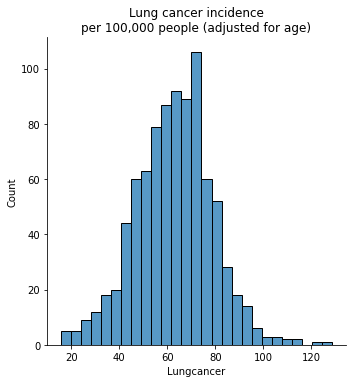

In [35]:
sns.displot(df["Lungcancer"])
plt.title("Lung cancer incidence\nper 100,000 people (adjusted for age)")
#plt.savefig('lungcancer.png', dpi = 500, bbox_inches='tight')
plt.show()

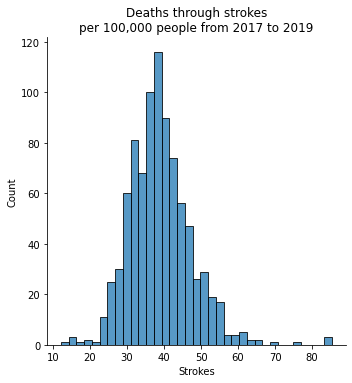

In [36]:
sns.displot(df["Strokes"])
plt.title("Deaths through strokes\nper 100,000 people from 2017 to 2019")
#plt.savefig('strokes.png', dpi = 500, bbox_inches='tight')
plt.show()

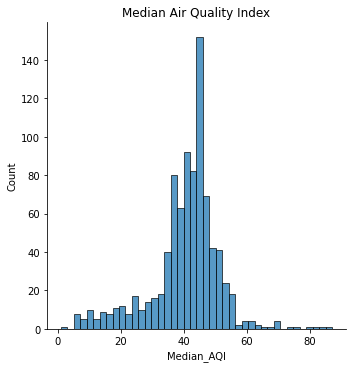

In [37]:
sns.displot(df["Median_AQI"])
plt.title("Median Air Quality Index")
#plt.savefig('air_quality.png', dpi = 500, bbox_inches='tight')
plt.show()

#### Relationship between main predictor and outcome variables

The scatterplots between one of our main predictors `Median_AQI` and the lung cancer/stroke incidence look fairly random. We will verify in our preliminary model in section 6 whether there is a significant correlation after controlling for our other variables. 

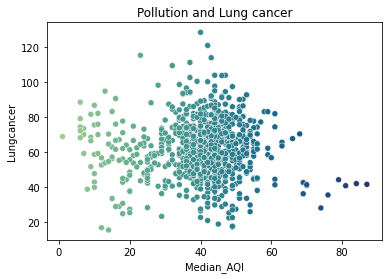

In [38]:
current_palette = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x = df["Median_AQI"], y = df["Lungcancer"], 
                c = df["Median_AQI"],
                cmap = current_palette)
plt.title("Pollution and Lung cancer")
plt.show()

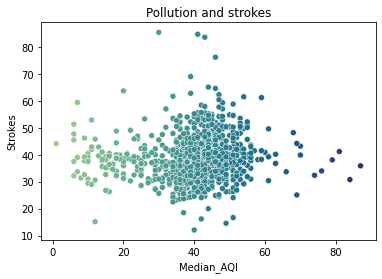

In [39]:
current_palette = sns.color_palette("crest", as_cmap=True)
sns.scatterplot(x = df["Median_AQI"], y = df["Strokes"], 
                c = df["Median_AQI"],
                cmap = current_palette)
plt.title("Pollution and strokes")
plt.show()

#### Distribution by state
There seems to be a quite even representation of states. Only a few states are missing which are not very populated or not in the continental United States.

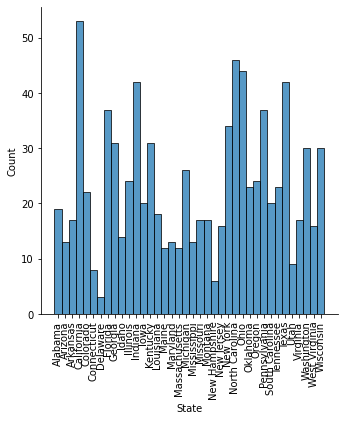

In [40]:
sns.displot(df["State"])
plt.xticks(rotation=90)
#plt.savefig('states.png', dpi = 500, bbox_inches='tight')
plt.show()

#### Missing states

In [41]:
print(set(states["State"]) - set(df["State"]))

{'Kansas', 'Nevada', 'New Mexico', 'North Dakota', 'Hawaii', 'Minnesota', 'Vermont', 'South Dakota', 'Nebraska', 'Alaska', 'Rhode Island', 'Wyoming'}


# 4. Definition of `X` and `y`

We will try to answer three questions in this project. Please see Section 5 for the specific questions.

The dependent variable for each of the three questions is different. Therefore, we split our data differently for each questions.
`X1` and `y1` relate to question 1, `X2` and `y3` will help us answer question 2, and lastly, `X3` and `y3` will give us the necessary data to take a step back and look at social problems related to pollution and thereby answer question 3.

In question 1 and 2, we choose predictors according to our medical research [1]. To predict strokes, we use all variables that may affect someone's likelihood of suffering a stroke: Obesity, significant alcohol consumption, diabetes, age, and pollution. We are particularly interested in the relationship between pollution and strokes, however, we need to other predictors to "control" for those influences. Similarly, to predict lung cancer, we select smoking, asbestos and radon prevalance, age, and pollution [2]. Again, we are primarily interested in the possible effect of pollution on lung cancer. 

In question 3, we try to predict the pollution itself according to demographic factors such as income, unemployment rate (serving as an indicator for economic prosperity), population density (indicating ruralness), poverty, race, and ethnicity. 




**Sources for control variables:**

[1] Strokes: https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113

[2] Lung Cancer: https://www.cancer.org/cancer/lung-cancer/causes-risks-prevention/what-causes.html

In [42]:
y1 = df["Strokes"]
y2 = df["Lungcancer"]
y3 = df["Median_AQI"]

In [43]:
X1 = df[["Obesity", "Alcohol", "Diabetes", "Age65AndOlderPct2010",
       # additionally, we will use (and later select from) the pollution data
       'Median_AQI', 'Unhealthy_days', 'CO',
       'NO2', 'Ozone', 'SO2', 'PM2.5', 'PM10']]
X2 = df[["Smoking", "Asbestos", "averageRadonLevel", 
        # "Age65AndOlderPct2010", -- not included because it is already age-adjusted
        # additionally, we will use (and later select from) the pollution data
       'Median_AQI', 'Unhealthy_days', 'CO',
       'NO2', 'Ozone', 'SO2', 'PM2.5', 'PM10']]
X3 = df[['Median_Income','UnempRate2019','PopDensity2010',
       'Poverty_Rate', #'Deep_Poverty', #'WhiteNonHispanicPct2010',
       'BlackNonHispanicPct2010', 'AsianNonHispanicPct2010',
       'NativeAmericanNonHispanicPct2010', 'HispanicPct2010',
       'MultipleRacePct2010']]


#### Correlation matrices
We can now produce the correlation matrices for each dataset.

After some iterations and removals of highly correlated variables, there are three noteworthy correlations left:
- `Diabetes` and `Obesity`: They have a correlation coefficient of `0.76` (rounded below). This is high, however, not high enough so that we could say that the effect of one is fully captured in the other variable. Thus, we cannot remove either -- both are crucial to the prediction of strokes. Nevertheless, we will treat the coefficients and p-values of these two features carefully.
- `Ozone` and `PM2.5`: These two variables are correlated by `0.81`. After examining the effects of removing either, we decided to drop `Ozone` from our dataset.
- `Poverty_Rate` and `Median_Income`: These two variables have a correlation coefficient of `0.77`. We may choose to select only one per model through stepwise feature selection and shrinkage methods later. Because there are not close to `1`, we do not want to remove either now because they may both offer valuable insights.
- Sadly yet not surprisingly, there also appears to be an overall correlation between race and poverty, presumably due to structural racism and historical injusticies. We cannot remove either variable, yet is important to keep this in mind as we progress. We will return to the question of social justice in greater detail in our final analysis.

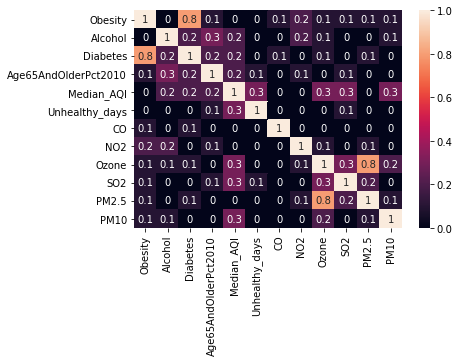

In [44]:
sns.heatmap(X1.corr().round(1).abs(), annot = True)
#plt.savefig('corr-1.png', dpi = 500, bbox_inches='tight')
plt.show()

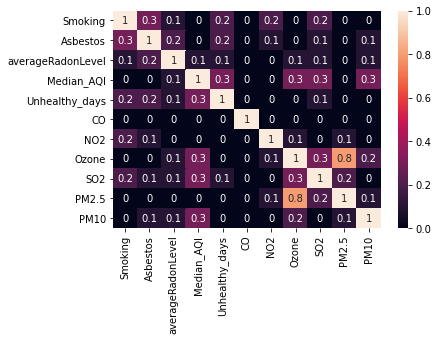

In [45]:
sns.heatmap(X2.corr().round(1).abs(), annot = True)
#plt.savefig('corr-2.png', dpi = 500, bbox_inches='tight')
plt.show()

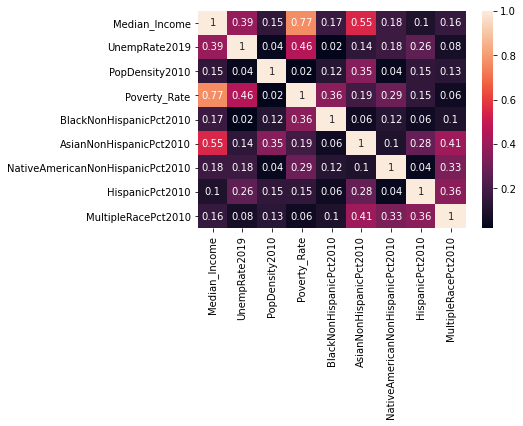

In [46]:
sns.heatmap(X3.corr().round(2).abs(), annot = True)
#plt.savefig('corr-3.png', dpi = 500, bbox_inches='tight')
plt.show()

# Models

Subsequently, we will fit linear models respectively for all three of our questions, followed by GAMs, Ridge and Lasso, and lastly, random forest regressors. 

We have chosen the models as they are the most interpretable and can allow for the best inference given our posed questions.

The best for each question will be chosen in section 9 when we weigh the different advantages and disadvantages of each model and interpret the final models' results.


# 5. Linear models

We will now fit a linear model to our data to check that it is working properly. 
This model will also serve as a baseline model for our futher analysis. Due to its simplicity and interpretivity, it is a good comparison to more complex models.

We are creating training and testing datasets for our three questions. We stratify by state so that all states' counties are equally represented in the train and test data.

These datasets will be used for all subsequent models to allow for a "fair" comparison.

In [47]:
# Question 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,
                                                        test_size = 0.2,
                                                        random_state = 314, #used for reproducibility
                                                        stratify = df["State"])

# Question 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,
                                                        test_size = 0.2,
                                                        random_state = 314,
                                                        stratify = df["State"])

# Question 3
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3,
                                                        test_size = 0.2,
                                                        random_state = 314,
                                                        stratify = df["State"])

**all 'rl' dataframes will be used for ridge and lasso models as a form of feature selection because dropping Ozone improves the Ridge and Lasso models because it is highly correlated with PM2.5. 

We can now fit the three models.

#### Question 1: Are there more strokes in counties with high pollution?

In [48]:
lm_model1 = sm.OLS(y1_train,X1_train) # call model with data
fitted_model1 = lm_model1.fit() # fit model
y1_train_pred = fitted_model1.predict(X1_train) # predict on training data
y1_pred = fitted_model1.predict(X1_test) # predict on testing data
print("Training MSE:       ", mean_squared_error(y1_train, y1_train_pred).round(3)) # calculate train MSE
print("Testing MSE:        ", mean_squared_error(y1_test, y1_pred).round(3)) # calculate test MSE
fitted_model1.summary2() # print summary for coefficients and p-values

Training MSE:        54.866
Testing MSE:         38.178


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:               OLS              Adj. R-squared:     0.224    
Dependent Variable:  Strokes          AIC:                4834.4706
Date:                2021-12-09 20:32 BIC:                4889.1349
No. Observations:    703              Log-Likelihood:     -2405.2  
Df Model:            11               F-statistic:        19.42    
Df Residuals:        691              Prob (F-statistic): 3.20e-34 
R-squared:           0.236            Scale:              55.819   
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
Obesity               0.4107   0.1059  3.8776 0.0001  0.2027 0.6187
Alcohol               0.0444   0.1220  0.3640 0.7160 -0.1951 0.2839
Diabetes              1.0873   0.2287  4.7545 0.0000  0.6383 1.5363
Age65AndOlderPct2010 -0.0181   0.0835 -0.2172 0.8281 -0.1822 0.1459
Median_AQI            0.0296   0.0329  0.8998 0.3685 -0.0350 0.0941
Unhealthy_days       -0.1426   0.0768 -1.8557 0.0639 -0.2934 0.0083
CO                   -0.0161   0.0760 -0.2118 0.8323 -0.1653 0.1331
NO2                  -0.0042   0.0156 -0.2709 0.7866 -0.0349 0.0265
Ozone                 0.0182   0.0100  1.8263 0.0682 -0.0014 0.0377
SO2                   0.0240   0.0110  2.1793 0.0296  0.0024 0.0457
PM2.5                 0.0204   0.0101  2.0206 0.0437  0.0006 0.0401
PM10                  0.0110   0.0108  1.0175 0.3093 -0.0102 0.0322
-------------------------------------------------------------------
Omnibus:             179.784       Durbin-Watson:          2.012   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       1032.657
Skew:                1.015         Prob(JB):               0.000   
Kurtosis:            8.580         Condition No.:          224     
===================================================================

"""

This model has a number of coefficients with significant p-values. `Obesity`, `Diabetes`, `SO2` (pollution) and `PM2.5` seem to be significantly correlated with our dependent variable `Strokes`. Through feature selection we would be able to delineate the effect more clearly in the future.

The r-squared of the model is only 24% which is rather low. A more complex model may be needed. The large difference between train and test MSE may suggest this, too.

#### Feature Selection

To refine our model, we will now perform feature selection on our dataset. This will find the best predictors for each model size through forward selection and cross validation.

We will print the best combination of predictors and the associated CV MSE error for each `k`.

In [49]:
cv_error = []
k = 10
model = LinearRegression() # call linear model from scikit-learn
for n_features in range(1, len(X1_train.columns)): # loop through the amount of columns that we have
    print("\nModel with",n_features,"predictors:") # print headline
    sfs = SequentialFeatureSelector(model, # call selector
                                    n_features_to_select = n_features, 
                                    direction = "forward", # chosen method
                                    scoring = 'neg_mean_squared_error', # chosen metric
                                    cv = k) 
    sfs = sfs.fit(X1_train, y1_train) # fitting for our data
    
    #extracting the selected predictors for optimal model
    columns_selected = X1_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X1_train[columns_selected], y1_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            58.182597145559555
Selected predictors: Index(['Obesity'], dtype='object')

Model with 2 predictors:
CV error:            56.72261331685488
Selected predictors: Index(['Obesity', 'Diabetes'], dtype='object')

Model with 3 predictors:
CV error:            56.592248671080974
Selected predictors: Index(['Obesity', 'Diabetes', 'Unhealthy_days'], dtype='object')

Model with 4 predictors:
CV error:            56.52524769056225
Selected predictors: Index(['Obesity', 'Diabetes', 'Median_AQI', 'Unhealthy_days'], dtype='object')

Model with 5 predictors:
CV error:            56.52186926338834
Selected predictors: Index(['Obesity', 'Diabetes', 'Median_AQI', 'Unhealthy_days', 'SO2'], dtype='object')

Model with 6 predictors:
CV error:            56.58915101687319
Selected predictors: Index(['Obesity', 'Alcohol', 'Diabetes', 'Median_AQI', 'Unhealthy_days',
       'SO2'],
      dtype='object')

Model with 7 predictors:
CV error:            56.6755050947

The best model has five parameters (`Obesity`, `Diabetes`, `Median_AQI`, `Unhealthy_days`, `SO2`) and a CV error of `56.5219`

In [50]:
lm_model1b = sm.OLS(y1_train,X1_train[['Obesity', 'Diabetes', 'Median_AQI', 'Unhealthy_days', 'SO2']]) 
# fitting model with the best parameters
fitted_model1b = lm_model1b.fit()
y1_train_pred = fitted_model1b.predict(X1_train[['Obesity', 'Diabetes', 'Median_AQI', 'Unhealthy_days', 'SO2']])
y1_pred = fitted_model1b.predict(X1_test[['Obesity', 'Diabetes', 'Median_AQI', 'Unhealthy_days', 'SO2']])
print("Training MSE:       ", mean_squared_error(y1_train, y1_train_pred).round(3)) #printing MSE
print("Testing MSE:        ", mean_squared_error(y1_test, y1_pred).round(3))
fitted_model1b.summary2()
print("R2: ", fitted_model1b.rsquared.round(3))

Training MSE:        55.746
Testing MSE:         37.426
R2:  0.965


This test MSE is better than the original MSE of the model with all parameters. That is a good sign as it means that we have reduced overfitting to irrelevant feature.

#### Question 2: Is there a higher lung cancer incidence in counties with high pollution?

In [51]:
lm_model2 = sm.OLS(y2_train,X2_train) # calling the model
fitted_model2 = lm_model2.fit() # fitting the model
y2_train_pred = fitted_model2.predict(X2_train) # predicting on train data
y2_pred = fitted_model2.predict(X2_test) # predicting on test data
print("Training MSE:       ", mean_squared_error(y2_train, y2_train_pred).round(3)) # train MSE
print("Testing MSE:        ", mean_squared_error(y2_test, y2_pred).round(3)) # test MSE
fitted_model2.summary2() # print summary

Training MSE:        104.46
Testing MSE:         80.712


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:                OLS              Adj. R-squared:     0.597    
Dependent Variable:   Lungcancer       AIC:                5285.1368
Date:                 2021-12-09 20:32 BIC:                5335.2457
No. Observations:     703              Log-Likelihood:     -2631.6  
Df Model:             10               F-statistic:        104.8    
Df Residuals:         692              Prob (F-statistic): 2.21e-131
R-squared:            0.602            Scale:              106.12   
--------------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
--------------------------------------------------------------------
Smoking           328.5993  11.5162 28.5338 0.0000 305.9885 351.2101
Asbestos           -0.0275   0.0126 -2.1728 0.0301  -0.0523  -0.0026
averageRadonLevel  -0.0374   0.1893 -0.1978 0.8433  -0.4091   0.3342
Median_AQI          0.0198   0.0435  0.4563 0.6483  -0.0655   0.1051
Unhealthy_days     -0.2410   0.1087 -2.2167 0.0270  -0.4544  -0.0275
CO                  0.0430   0.1049  0.4096 0.6823  -0.1630   0.2489
NO2                -0.0778   0.0206 -3.7739 0.0002  -0.1182  -0.0373
Ozone              -0.0587   0.0102 -5.7531 0.0000  -0.0787  -0.0386
SO2                -0.0588   0.0125 -4.6867 0.0000  -0.0834  -0.0342
PM2.5              -0.0625   0.0102 -6.1447 0.0000  -0.0824  -0.0425
PM10               -0.0887   0.0115 -7.7259 0.0000  -0.1112  -0.0661
--------------------------------------------------------------------
Omnibus:               30.954        Durbin-Watson:           2.124 
Prob(Omnibus):         0.000         Jarque-Bera (JB):        86.449
Skew:                  -0.084        Prob(JB):                0.000 
Kurtosis:              4.710         Condition No.:           7604  
====================================================================
* The condition number is large (8e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

The r-squared of this model is already much higher at 60%. Almost all pollution predictors are significant as well as our control variables for smoking, asbestos and age. The difference between test and train MSE is not too high.

In [52]:
cv_error = []
k = 10
model = LinearRegression() # call linear model from scikit-learn
for n_features in range(1, len(X2_train.columns)): # loop through the amount of columns that we have
    print("\nModel with",n_features,"predictors:") # print headline
    sfs = SequentialFeatureSelector(model, # call selector
                                    n_features_to_select = n_features, 
                                    direction = "forward", # chosen method
                                    scoring = 'neg_mean_squared_error', # chosen metric
                                    cv = k) 
    sfs = sfs.fit(X2_train, y2_train) # fitting for our data
    
    #extracting the selected predictors for optimal model
    columns_selected = X2_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X2_train[columns_selected], y2_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            109.36473652238885
Selected predictors: Index(['Smoking'], dtype='object')

Model with 2 predictors:
CV error:            108.26718118775204
Selected predictors: Index(['Smoking', 'PM10'], dtype='object')

Model with 3 predictors:
CV error:            107.47212269463144
Selected predictors: Index(['Smoking', 'Asbestos', 'PM10'], dtype='object')

Model with 4 predictors:
CV error:            107.11647223762589
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10'], dtype='object')

Model with 5 predictors:
CV error:            107.17260519028355
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'NO2', 'PM10'], dtype='object')

Model with 6 predictors:
CV error:            107.24010966780538
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'NO2', 'PM2.5', 'PM10'], dtype='object')

Model with 7 predictors:
CV error:            107.43213039528908
Selected predictors: Index(['Smoking'

In [53]:
lm_model2b = sm.OLS(y2_train,X2_train[['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']]) # calling the model
fitted_model2b = lm_model2b.fit() # fitting the model
y2_train_pred = fitted_model2b.predict(X2_train[['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']]) # predicting on train data
y2_pred = fitted_model2b.predict(X2_test[['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']]) # predicting on test data
print("Training MSE:       ", mean_squared_error(y2_train, y2_train_pred).round(3)) # train MSE
print("Testing MSE:        ", mean_squared_error(y2_test, y2_pred).round(3)) # test MSE
fitted_model2b.summary2() # print summary

Training MSE:        112.243
Testing MSE:         85.82


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.973    
Dependent Variable:     Lungcancer       AIC:                         5321.6565
Date:                   2021-12-09 20:32 BIC:                         5339.8779
No. Observations:       703              Log-Likelihood:              -2656.8  
Df Model:               4                F-statistic:                 6375.    
Df Residuals:           699              Prob (F-statistic):          0.00     
R-squared (uncentered): 0.973            Scale:                       112.89   
---------------------------------------------------------------------------------
                     Coef.     Std.Err.      t       P>|t|     [0.025     0.975] 
---------------------------------------------------------------------------------
Smoking             254.4729     2.4489   103.9115   0.0000   249.6647   259.2810
Asbestos             -0.0623     0.0117    -5.3261   0.0000    -0.0853    -0.0394
Unhealthy_days       -0.2808     0.0998    -2.8132   0.0050    -0.4767    -0.0848
PM10                 -0.0339     0.0076    -4.4745   0.0000    -0.0487    -0.0190
-------------------------------------------------------------------------------
Omnibus:                  33.871            Durbin-Watson:               2.104 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            99.280
Skew:                     0.105             Prob(JB):                    0.000 
Kurtosis:                 4.829             Condition No.:               356   
===============================================================================

"""

This tuned model performs significantly worse than the first model in terms of test MSE.


#### Question 3: Are marginalised demographics more likely to live in counties with high pollution?

In [54]:
lm_model3 = sm.OLS(y3_train,X3_train)
fitted_model3 = lm_model3.fit()
y3_train_pred = fitted_model3.predict(X3_train)
y3_pred = fitted_model3.predict(X3_test)
print("Training MSE:       ", mean_squared_error(y3_train, y3_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y3_test, y3_pred).round(3))
fitted_model3.summary2()

Training MSE:        120.928
Testing MSE:         124.932


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                   OLS              Adj. R-squared (uncentered): 0.930    
Dependent Variable:      Median_AQI       AIC:                         5384.0512
Date:                    2021-12-09 20:32 BIC:                         5425.0495
No. Observations:        703              Log-Likelihood:              -2683.0  
Df Model:                9                F-statistic:                 1034.    
Df Residuals:            694              Prob (F-statistic):          0.00     
R-squared (uncentered):  0.931            Scale:                       122.50   
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------
Median_Income                     0.0004   0.0000 23.6337 0.0000  0.0004  0.0005
UnempRate2019                     0.4396   0.3226  1.3628 0.1734 -0.1938  1.0730
PopDensity2010                    0.0000   0.0001  0.1960 0.8447 -0.0002  0.0003
Poverty_Rate                      0.8236   0.0920  8.9527 0.0000  0.6430  1.0042
BlackNonHispanicPct2010           0.1957   0.0408  4.7990 0.0000  0.1156  0.2758
AsianNonHispanicPct2010          -0.5931   0.1735 -3.4183 0.0007 -0.9337 -0.2524
NativeAmericanNonHispanicPct2010 -0.2188   0.0824 -2.6550 0.0081 -0.3806 -0.0570
HispanicPct2010                   0.0083   0.0359  0.2305 0.8178 -0.0621  0.0787
MultipleRacePct2010               0.3169   0.3931  0.8062 0.4204 -0.4549  1.0887
--------------------------------------------------------------------------------
Omnibus:                   33.398            Durbin-Watson:               1.845 
Prob(Omnibus):             0.000             Jarque-Bera (JB):            83.221
Skew:                      -0.202            Prob(JB):                    0.000 
Kurtosis:                  4.636             Condition No.:               58243 
================================================================================
* The condition number is large (6e+04). This might indicate             strong
multicollinearity or other numerical problems.
"""

With an r-squared of 93%, this is our best performing linear model. Training and testing error are very similar which means that the model generalises well to unseen data. All but four predictors are highly significant.

In [55]:
cv_error = []
k = 10
model = LinearRegression() # call linear model from scikit-learn
for n_features in range(1, len(X3_train.columns)): # loop through the amount of columns that we have
    print("\nModel with",n_features,"predictors:") # print headline
    sfs = SequentialFeatureSelector(model, # call selector
                                    n_features_to_select = n_features, 
                                    direction = "forward", # chosen method
                                    scoring = 'neg_mean_squared_error', # chosen metric
                                    cv = k) 
    sfs = sfs.fit(X3_train, y3_train) # fitting for our data
    
    #extracting the selected predictors for optimal model
    columns_selected = X3_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X3_train[columns_selected], y3_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            116.11821975560056
Selected predictors: Index(['BlackNonHispanicPct2010'], dtype='object')

Model with 2 predictors:
CV error:            113.54167040440643
Selected predictors: Index(['Median_Income', 'BlackNonHispanicPct2010'], dtype='object')

Model with 3 predictors:
CV error:            112.62550532419615
Selected predictors: Index(['Median_Income', 'BlackNonHispanicPct2010', 'HispanicPct2010'], dtype='object')

Model with 4 predictors:
CV error:            112.56463420424913
Selected predictors: Index(['Median_Income', 'Poverty_Rate', 'BlackNonHispanicPct2010',
       'HispanicPct2010'],
      dtype='object')

Model with 5 predictors:
CV error:            112.52778039840084
Selected predictors: Index(['Median_Income', 'PopDensity2010', 'Poverty_Rate',
       'BlackNonHispanicPct2010', 'HispanicPct2010'],
      dtype='object')

Model with 6 predictors:
CV error:            112.69208064482068
Selected predictors: Index(['Median_Income'

In [56]:
lm_model3b = sm.OLS(y3_train,X3_train[['Median_Income', 'PopDensity2010', 'Poverty_Rate',
       'BlackNonHispanicPct2010', 'HispanicPct2010']]) # calling the model
fitted_model3b = lm_model3b.fit() # fitting the model
y3_train_pred = fitted_model3b.predict(X3_train[['Median_Income', 'PopDensity2010', 'Poverty_Rate',
       'BlackNonHispanicPct2010', 'HispanicPct2010']]) # predicting on train data
y3_pred = fitted_model3b.predict(X3_test[['Median_Income', 'PopDensity2010', 'Poverty_Rate',
       'BlackNonHispanicPct2010', 'HispanicPct2010']]) # predicting on test data
print("Training MSE:       ", mean_squared_error(y3_train, y3_train_pred).round(3)) # train MSE
print("Testing MSE:        ", mean_squared_error(y3_test, y3_pred).round(3)) # test MSE
fitted_model3b.summary2() # print summary

Training MSE:        124.907
Testing MSE:         123.902


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.928    
Dependent Variable:     Median_AQI       AIC:                         5398.8114
Date:                   2021-12-09 20:32 BIC:                         5421.5882
No. Observations:       703              Log-Likelihood:              -2694.4  
Df Model:               5                F-statistic:                 1808.    
Df Residuals:           698              Prob (F-statistic):          0.00     
R-squared (uncentered): 0.928            Scale:                       125.80   
--------------------------------------------------------------------------------
                              Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
--------------------------------------------------------------------------------
Median_Income                 0.0004    0.0000  33.0700  0.0000   0.0004  0.0005
PopDensity2010               -0.0001    0.0001  -0.9598  0.3375  -0.0004  0.0001
Poverty_Rate                  0.9227    0.0591  15.6207  0.0000   0.8067  1.0387
BlackNonHispanicPct2010       0.1907    0.0391   4.8724  0.0000   0.1138  0.2675
HispanicPct2010               0.0046    0.0329   0.1396  0.8891  -0.0601  0.0692
-------------------------------------------------------------------------------
Omnibus:                  29.386            Durbin-Watson:               1.823 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            57.509
Skew:                     -0.259            Prob(JB):                    0.000 
Kurtosis:                 4.302             Condition No.:               9188  
===============================================================================
* The condition number is large (9e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

This model is slightly better than the linear model with all predictors, however, it still holds little value for our inference because 2 out of 5 predictors are insignificant.

This concludes our data cleaning and preliminary analysis. We will refine our models and build more complex ones in the final draft of this project.

# 6. GAM 

We are now fitting a General Additive Model on our data

We will go question by question. 

### Question 1: Are there more strokes in counties with high pollution?

Our predictor variables are:
'Obesity', 'Alcohol', 'Diabetes', 'Age65AndOlderPct2010', 'Median_AQI',
'Unhealthy_days', 'CO', 'NO2', 'Ozone', 'SO2', 'PM2.5', 'PM10'. 

They are contained in the dataframe `X1_train`.

In [57]:
X1_train.head()

,Obesity,Alcohol,Diabetes,Age65AndOlderPct2010,Median_AQI,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10
318,37.05,16.8,14.65,13.37,51,3.000000,5.0,0.0,206.000000,109.0,32.000000,13.0
299,37.90,18.7,13.61,18.43,31,0.000000,0.0,0.0,0.000000,0.0,365.000000,0.0
690,35.70,13.7,13.21,18.86,52,1.022409,0.0,0.0,90.994398,0.0,274.005602,0.0
438,38.80,14.3,14.55,13.38,39,0.000000,0.0,0.0,203.000000,0.0,0.000000,162.0
790,34.40,12.7,12.72,12.71,43,0.000000,0.0,0.0,365.000000,0.0,0.000000,0.0


We will first fit a complex model with up to 20 degrees for all parameters. Subsequently, we will narrow it down to fewer degrees and fewer parameters.

In [58]:
X = X1_train.apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y1_train)
X = np.concatenate((X, np.array([[0] * X1_train.shape[1]]) )) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11)) # using all 12 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Model has been fitted.


We now return the summary. 

It becomes apparant that only three of our variables are significant.

In [59]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     30.4656
Link Function:                     IdentityLink Log Likelihood:                                  -3458.002
Number of Samples:                          704 AIC:                                             6978.9352
                                                AICc:                                            6981.9777
                                                GCV:                                               58.2562
                                                Scale:                                             53.7366
                                                Pseudo R-Squared:                                   0.3039
Feature Function                  Lam

<ipython-input-59-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Furthermore, our model does not seem to perform significantly better than the linear baseline that had a test MSE of `38.178`.

In [60]:
means = X1_train.mean()
X1_test_centered = X1_test
for i in X1_train.columns:
    for j in X1_test_centered.index:
        X1_test_centered.at[j,i] = X1_test.at[j,i] - means[i]
y1_pred = gam.predict(X1_test_centered)
print("Training MSE:       ", mean_squared_error(y1_train, y1_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y1_test, y1_pred).round(3))

Training MSE:        55.746
Testing MSE:         38.059


To confirm our suspicion, we can see from the plots below that our models output is quite random. 

<Figure size 432x288 with 0 Axes>

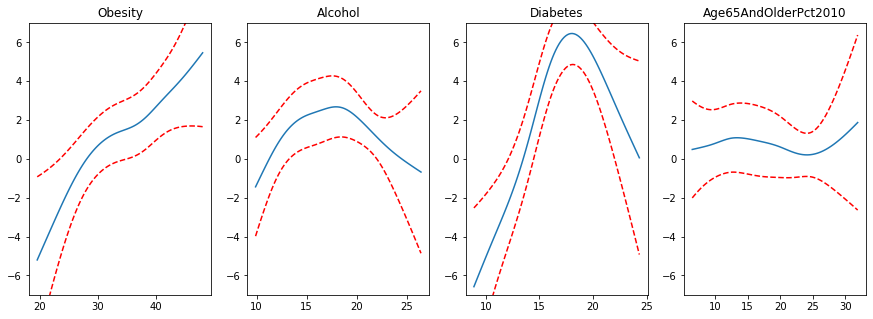

<Figure size 432x288 with 0 Axes>

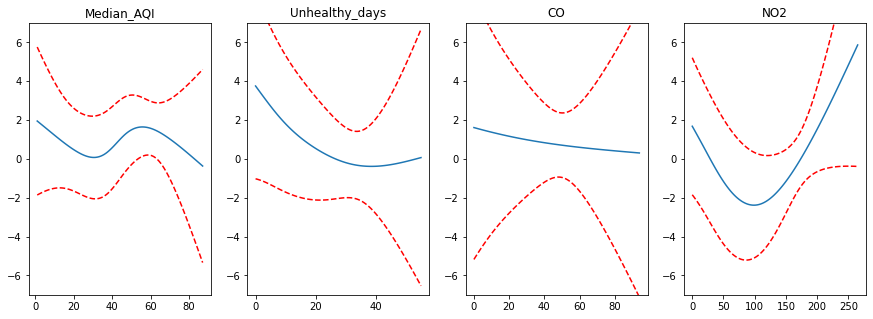

<Figure size 432x288 with 0 Axes>

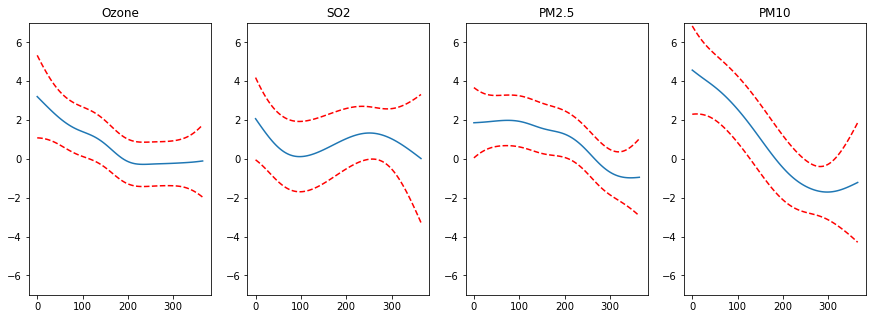

In [61]:
# This code prints the relevant plots of our model. 
# The code structure is the same as in the documentation of this pyGAM library. 
# The link to the documentation can be found in the list of references below.
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = X1_train.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X1_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X1_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_ylim(-7,7)
    ax.set_title(titles[i])
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = X1_train.columns
for i, ax in enumerate(axs):
    j = i + 4
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:, j] + X1_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:, j] + X1_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = X1_train.columns
for i, ax in enumerate(axs):
    j = i + 8
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:, j] + X1_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:, j] + X1_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()

We must therefore narrow down the number of predictors used as well as the degrees of freedom allowed. We start with the degrees of freedom, reducing them from 20 to 5.

In [62]:
X = X1_train.apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y1_train)
X = np.concatenate((X, np.array([[0] * X1_train.shape[1]]) )) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
DoF = 5
gam = LinearGAM(s(0, n_splines=DoF) + s(1, n_splines=DoF) + s(2, n_splines=DoF)+ s(3, n_splines=DoF) +
                s(4, n_splines=DoF) + s(5, n_splines=DoF) + s(6, n_splines=DoF)+ s(7, n_splines=DoF) +
                s(8, n_splines=DoF) + s(9, n_splines=DoF) + s(11, n_splines=DoF))
gam.gridsearch(X, y)
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Model has been fitted.


In [63]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.6811
Link Function:                     IdentityLink Log Likelihood:                                 -3484.9647
Number of Samples:                          704 AIC:                                             7009.2916
                                                AICc:                                            7010.4829
                                                GCV:                                                58.639
                                                Scale:                                              55.845
                                                Pseudo R-Squared:                                   0.2639
Feature Function                  Lam

<ipython-input-63-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


This does not have a big effect on the variability of the model. It only reduces the overall `Effective DoF` from `25.6` to `18.7`. 

Instead, we will now focus on the selection of parameters. First, we will run a best subset selection algorithm. This algorithm is based on a linear model. Nevertheless, it would be a good indicator as to whether there is any form of relationship between the respective predictor and the target variable.

In [64]:
cv_error = []
k = 10
model = LinearRegression()
for i in range(1, len(X1_train.columns)):
    print("\nModel with",i,"predictors:")
    n_features = i
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = n_features, 
                                    direction = "backward",
                                    scoring = 'neg_mean_squared_error',
                                    cv = k) 
    sfs = sfs.fit(X1_train, y1_train)
    
    #extracting the selected predictors for optimal model
    columns_selected = X1_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X1_train[columns_selected], y1_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            58.182597145559555
Selected predictors: Index(['Obesity'], dtype='object')

Model with 2 predictors:
CV error:            56.72261331685488
Selected predictors: Index(['Obesity', 'Diabetes'], dtype='object')

Model with 3 predictors:
CV error:            56.592248671080974
Selected predictors: Index(['Obesity', 'Diabetes', 'Unhealthy_days'], dtype='object')

Model with 4 predictors:
CV error:            56.556016748626725
Selected predictors: Index(['Obesity', 'Diabetes', 'Unhealthy_days', 'PM10'], dtype='object')

Model with 5 predictors:
CV error:            56.70690918030764
Selected predictors: Index(['Obesity', 'Diabetes', 'Unhealthy_days', 'Ozone', 'PM10'], dtype='object')

Model with 6 predictors:
CV error:            56.751164729121726
Selected predictors: Index(['Obesity', 'Diabetes', 'Unhealthy_days', 'Ozone', 'PM2.5', 'PM10'], dtype='object')

Model with 7 predictors:
CV error:            56.83897202374025
Selected predictors: I

When we ran this code, the best number of predictors was `4` with a CV error of `56.56`.

Side note: It is not possible to use `LinearGAM` as the model with which do this feature selection.

The selected predictors are: 'Obesity', 'Diabetes', 'Unhealthy_days', 'PM10'.

We can now fit a new GAM:

In [65]:
X = X1_train[['Obesity', 'Diabetes', 'Unhealthy_days', 'PM10']].apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y1_train)
X = np.concatenate((X, np.array([[0] * X.shape[1]]))) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
DoF = 6
gam = LinearGAM(s(0, n_splines=DoF ) + s(1, n_splines=DoF) + s(2, n_splines=DoF) + s(3, n_splines=DoF)) # using all 12 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Model has been fitted.


In [66]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.7071
Link Function:                     IdentityLink Log Likelihood:                                  -3475.939
Number of Samples:                          704 AIC:                                              6977.292
                                                AICc:                                            6977.7967
                                                GCV:                                               56.8206
                                                Scale:                                             55.1223
                                                Pseudo R-Squared:                                   0.2661
Feature Function                  Lam

<ipython-input-66-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [67]:
y1_pred = gam.predict(X1_test_centered[['Obesity', 'Diabetes', 'Unhealthy_days', 'PM10']])
print("Training MSE:       ", mean_squared_error(y1_train, y1_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y1_test, y1_pred).round(3))

Training MSE:        55.746
Testing MSE:         38.486


<Figure size 432x288 with 0 Axes>

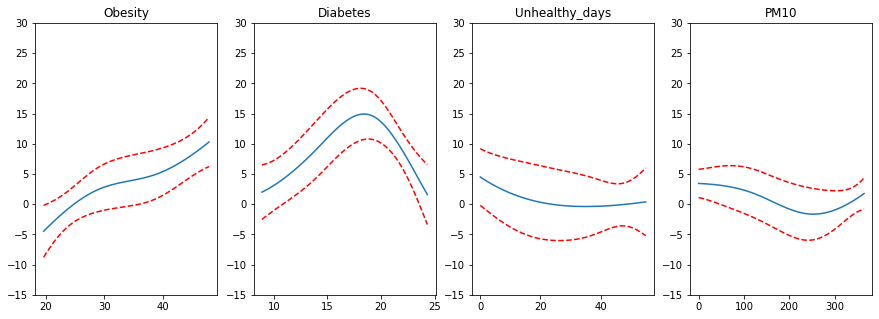

In [68]:
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = ['Obesity', 'Diabetes', 'Unhealthy_days', 'PM10']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X1_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X1_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_ylim(-15,30)
    ax.set_title(titles[i])


### Question 2:  Is there a higher lung cancer incidence in counties with high pollution?

Our predictor variables are: 'Smoking', 'Asbestos', 'averageRadonLevel', 'Median_AQI',
       'Unhealthy_days', 'CO', 'NO2', 'Ozone', 'SO2', 'PM2.5', 'PM10'.
       
They are contained in `X2_train`.

In [69]:
print(X2_train.shape)
X2_train.head()

(703, 11)


,Smoking,Asbestos,averageRadonLevel,Median_AQI,Unhealthy_days,CO,NO2,Ozone,SO2,PM2.5,PM10
318,0.295,12.666667,7.4,51,3.000000,5.0,0.0,206.000000,109.0,32.000000,13.0
299,0.267,10.000000,6.1,31,0.000000,0.0,0.0,0.000000,0.0,365.000000,0.0
690,0.276,86.400000,8.6,52,1.022409,0.0,0.0,90.994398,0.0,274.005602,0.0
438,0.297,13.666667,4.3,39,0.000000,0.0,0.0,203.000000,0.0,0.000000,162.0
790,0.225,47.600000,3.6,43,0.000000,0.0,0.0,365.000000,0.0,0.000000,0.0


Again, we will first fit a complex model with up to 20 degrees for all parameters. Subsequently, we will narrow it down to fewer degrees and fewer parameters.

In [70]:
X = X2_train.apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y2_train)
X = np.concatenate((X, np.array([[0] * X2_train.shape[1]]) )) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)) # using all 12 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Model has been fitted.


In [71]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.7185
Link Function:                     IdentityLink Log Likelihood:                                 -3941.0047
Number of Samples:                          704 AIC:                                             7925.4464
                                                AICc:                                            7926.8949
                                                GCV:                                               113.163
                                                Scale:                                            107.1846
                                                Pseudo R-Squared:                                   0.6117
Feature Function                  Lam

<ipython-input-71-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [72]:
means = X2_train.mean()
print(X2_train.shape)
X2_test_centered = X2_test
for i in X2_train.columns:
    for j in X2_test_centered.index:
        X2_test_centered.at[j,i] = X2_test.at[j,i] - means[i]
y2_pred = gam.predict(X2_test_centered)
print("Training MSE:       ", mean_squared_error(y2_train, y2_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y2_test, y2_pred).round(3))

(703, 11)
Training MSE:        112.243
Testing MSE:         77.825


<Figure size 432x288 with 0 Axes>

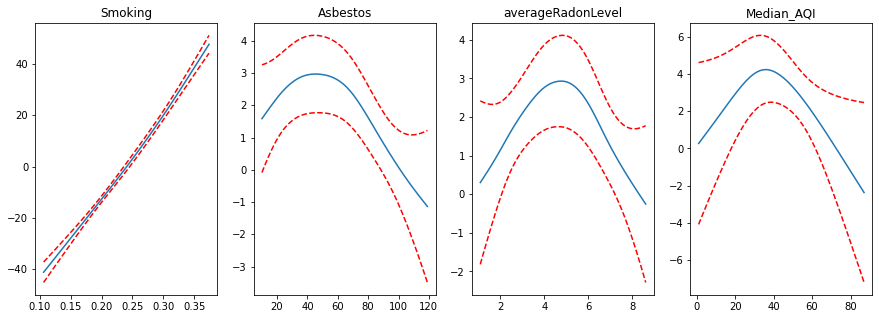

<Figure size 432x288 with 0 Axes>

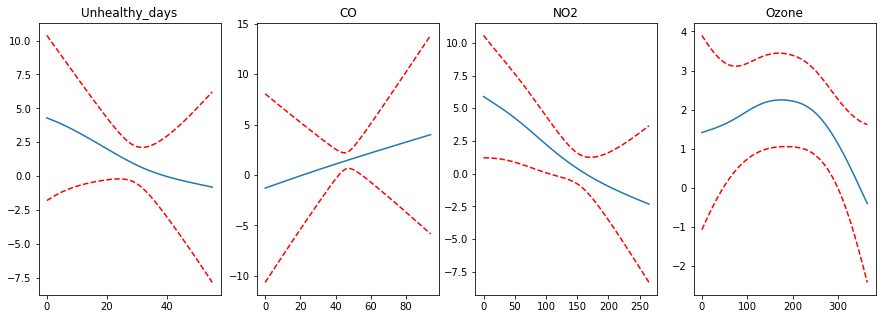

<Figure size 432x288 with 0 Axes>

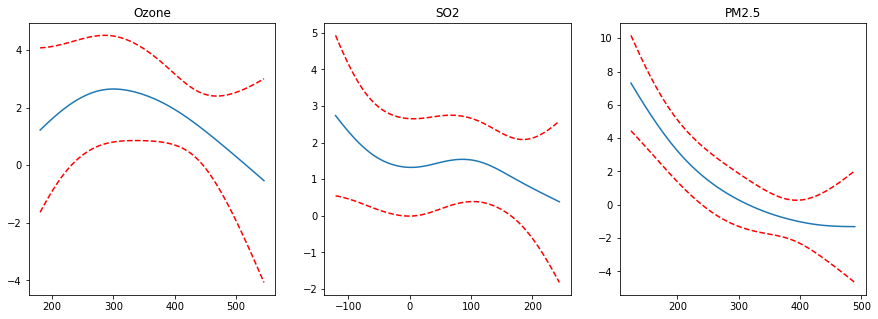

In [73]:
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = X2_train.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X2_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X2_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[i])
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = X2_train.columns
for i, ax in enumerate(axs):
    j = i + 4
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:, j] + X2_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:, j] + X2_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()
plt.figure();
fig, axs = plt.subplots(1,3,figsize=(15,5));
titles = X1_train.columns
for i, ax in enumerate(axs):
    j = i + 8
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:,j] + X2_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:,j] + X2_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()

In [74]:
X = X2_train.apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y2_train)
X = np.concatenate((X, np.array([[0] * X2_train.shape[1]]) )) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
DoF = 5
gam = LinearGAM(s(0, n_splines=DoF) + s(1, n_splines=DoF) + s(2, n_splines=DoF)+ s(3, n_splines=DoF) +
                s(4, n_splines=DoF) + s(5, n_splines=DoF) + s(6, n_splines=DoF)+ s(7, n_splines=DoF) +
                s(8, n_splines=DoF) + s(9, n_splines=DoF) + s(10, n_splines=DoF))
gam.gridsearch(X, y)
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Model has been fitted.


In [75]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.5355
Link Function:                     IdentityLink Log Likelihood:                                 -3943.2468
Number of Samples:                          704 AIC:                                             7925.5646
                                                AICc:                                            7926.7385
                                                GCV:                                              112.8623
                                                Scale:                                            107.5264
                                                Pseudo R-Squared:                                   0.6092
Feature Function                  Lam

<ipython-input-75-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


The features are less significant now than they were before. Furthermore, the degrees of freedom have barely reduced. The regulariser seems to do a good job by itself.

In [76]:
cv_error = []
k = 10
model = LinearRegression()
for i in range(1, len(X2_train.columns)):
    print("\nModel with",i,"predictors:")
    n_features = i
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = n_features, 
                                    direction = "backward",
                                    scoring = 'neg_mean_squared_error',
                                    cv = k) 
    sfs = sfs.fit(X2_train, y2_train)
    
    #extracting the selected predictors for optimal model
    columns_selected = X2_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X2_train[columns_selected], y2_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            109.36473652238885
Selected predictors: Index(['Smoking'], dtype='object')

Model with 2 predictors:
CV error:            108.26718118775204
Selected predictors: Index(['Smoking', 'PM10'], dtype='object')

Model with 3 predictors:
CV error:            107.47212269463144
Selected predictors: Index(['Smoking', 'Asbestos', 'PM10'], dtype='object')

Model with 4 predictors:
CV error:            107.11647223762589
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10'], dtype='object')

Model with 5 predictors:
CV error:            107.17260519028355
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'NO2', 'PM10'], dtype='object')

Model with 6 predictors:
CV error:            107.24010966780538
Selected predictors: Index(['Smoking', 'Asbestos', 'Unhealthy_days', 'NO2', 'PM2.5', 'PM10'], dtype='object')

Model with 7 predictors:
CV error:            107.48161662788695
Selected predictors: Index(['Smoking'

The model with four predictors seems to perform best.

CV error:            `107.1`.

Selected predictors: 'Smoking', 'Asbestos', 'Unhealthy_days', 'PM10'

In [77]:
X = X2_train[['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']].apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y2_train)
X = np.concatenate((X, np.array([[0] * X.shape[1]]))) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
DoF = 5
gam = LinearGAM(s(0, n_splines=DoF ) + s(1, n_splines=DoF) + s(2, n_splines=DoF) + s(3, n_splines=DoF)) # using all 12 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Model has been fitted.


In [78]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.8035
Link Function:                     IdentityLink Log Likelihood:                                 -3956.7412
Number of Samples:                          704 AIC:                                             7931.0894
                                                AICc:                                            7931.3381
                                                GCV:                                              111.8384
                                                Scale:                                            109.6092
                                                Pseudo R-Squared:                                   0.5954
Feature Function                  Lam

<ipython-input-78-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [79]:
y2_pred = gam.predict(X2_test_centered[['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']])
print("Training MSE:       ", mean_squared_error(y2_train, y2_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y2_test, y2_pred).round(3))

Training MSE:        112.243
Testing MSE:         82.033


<Figure size 432x288 with 0 Axes>

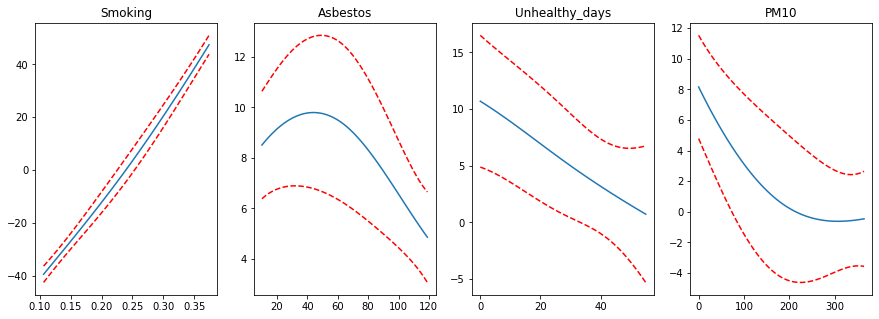

In [80]:
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = ['Smoking', 'Asbestos', 'Unhealthy_days', 'PM10']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X2_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X2_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-15,30)
    ax.set_title(titles[i])

### Question 3: Are marginalised demographics more likely to live in counties with high pollution?
Our predictor variables are: 'Median_Income', 'UnempRate2019', 'PopDensity2010', 'Poverty_Rate',
       'BlackNonHispanicPct2010', 'AsianNonHispanicPct2010',
       'NativeAmericanNonHispanicPct2010', 'HispanicPct2010',
       'MultipleRacePct2010'.
They are contained `X3_train`.

In [81]:
print(X3_train.shape)
X3_train.head()

(703, 9)


,Median_Income,UnempRate2019,PopDensity2010,Poverty_Rate,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010
318,56586.0,3.9,1948.12,14.240192,20.57,2.18,0.20,4.39,2.25
299,56037.0,3.1,24.64,11.950865,0.33,0.25,6.66,7.43,2.54
690,60471.0,4.6,355.38,10.007321,2.31,0.74,0.08,0.87,1.23
438,48357.0,3.0,183.88,17.100660,1.84,0.99,1.38,6.84,3.18
790,100783.0,2.3,100.71,5.809679,8.02,1.27,0.29,6.41,2.40


In [82]:
X = X3_train.apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y3_train)
X = np.concatenate((X, np.array([[0] * X3_train.shape[1]]) )) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8)) # using all 9 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Model has been fitted.


In [83]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.1057
Link Function:                     IdentityLink Log Likelihood:                                  -3905.482
Number of Samples:                          704 AIC:                                             7875.1755
                                                AICc:                                             7878.344
                                                GCV:                                              110.6585
                                                Scale:                                            101.8938
                                                Pseudo R-Squared:                                   0.2115
Feature Function                  Lam

<ipython-input-83-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [84]:
means = X3_train.mean()
print(X3_train.shape)
X3_test_centered = X3_test
for i in X3_train.columns:
    for j in X3_test_centered.index:
        X3_test_centered.at[j,i] = X3_test.at[j,i] - means[i]
y3_pred = gam.predict(X3_test_centered)
print("Training MSE:       ", mean_squared_error(y3_train, y3_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y3_test, y3_pred).round(3))

(703, 9)
Training MSE:        124.907
Testing MSE:         114.187


<Figure size 432x288 with 0 Axes>

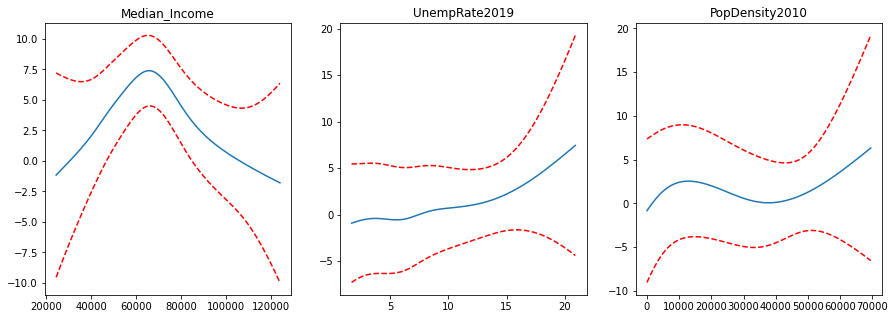

<Figure size 432x288 with 0 Axes>

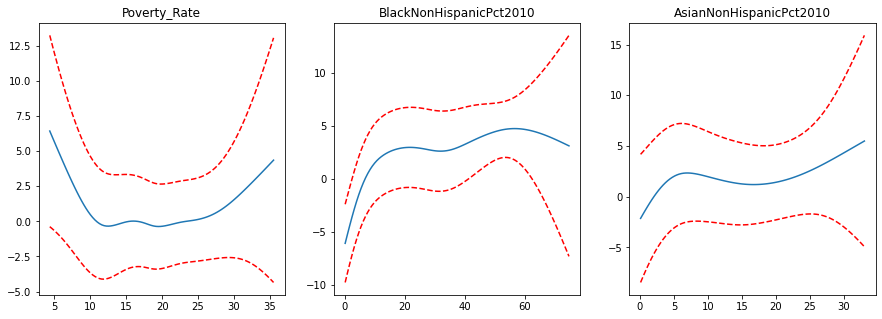

<Figure size 432x288 with 0 Axes>

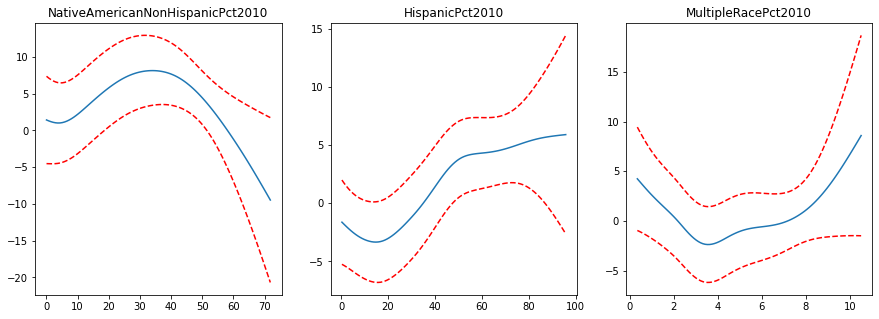

In [85]:
plt.figure();
fig, axs = plt.subplots(1,3,figsize=(15,5));
titles = X3_train.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X3_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X3_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[i])
plt.figure();
fig, axs = plt.subplots(1,3,figsize=(15,5));
titles = X3_train.columns
for i, ax in enumerate(axs):
    j = i + 3
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:, j] + X3_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:, j] + X3_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()
plt.figure();
fig, axs = plt.subplots(1,3,figsize=(15,5));
titles = X3_train.columns
for i, ax in enumerate(axs):
    j = i + 6
    XX = gam.generate_X_grid(term=j)
    ax.plot(XX[:,j] + X3_train[titles[j]].mean(), gam.partial_dependence(term=j, X=XX))
    ax.plot(XX[:,j] + X3_train[titles[j]].mean(), 
            gam.partial_dependence(term=j, X=XX, width=0.95)[1], c='r', ls='--')
    #ax.set_ylim(-7,7)
    ax.set_title(titles[j])
plt.show()

In [86]:
cv_error = []
k = 10
model = LinearRegression()
for i in range(1, len(X3_train.columns)):
    print("\nModel with",i,"predictors:")
    n_features = i
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = n_features, 
                                    direction = "backward",
                                    scoring = 'neg_mean_squared_error',
                                    cv = k) 
    sfs = sfs.fit(X3_train, y3_train)
    
    #extracting the selected predictors for optimal model
    columns_selected = X3_train.columns[sfs.get_support()]
    
    #calculating the mean error
    cv_avg = np.mean(cross_val_score(model, X3_train[columns_selected], y3_train, cv = k, scoring='neg_mean_squared_error')) * (-1)
    cv_error.append(cv_avg)
    
    #printing
    print("CV error:           ",cv_avg)
    print("Selected predictors:",columns_selected)


Model with 1 predictors:
CV error:            116.11821975560056
Selected predictors: Index(['BlackNonHispanicPct2010'], dtype='object')

Model with 2 predictors:
CV error:            114.15006315513581
Selected predictors: Index(['Poverty_Rate', 'BlackNonHispanicPct2010'], dtype='object')

Model with 3 predictors:
CV error:            112.26927177012006
Selected predictors: Index(['Poverty_Rate', 'BlackNonHispanicPct2010', 'HispanicPct2010'], dtype='object')

Model with 4 predictors:
CV error:            112.17087722284202
Selected predictors: Index(['PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010',
       'HispanicPct2010'],
      dtype='object')

Model with 5 predictors:
CV error:            112.25317500325598
Selected predictors: Index(['PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010',
       'AsianNonHispanicPct2010', 'HispanicPct2010'],
      dtype='object')

Model with 6 predictors:
CV error:            112.55840426484777
Selected predictors: Index(['PopDe

Best is four predictors: 'PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010',
       'HispanicPct2010'

In [87]:
X = X3_train[['PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010', 'HispanicPct2010']].apply(lambda x: x-x.mean())  # we are centering our data around the mean
X = np.array(X)                           # we are converting our data to a numpy array
y = np.array(y3_train)
X = np.concatenate((X, np.array([[0] * X.shape[1]]))) # we have to add an observation with all 0 for the algorithm to work.
y = np.concatenate((y, [0]))
DoF = 5
gam = LinearGAM(s(0, n_splines=DoF ) + s(1, n_splines=DoF) + s(2, n_splines=DoF) + s(3, n_splines=DoF)) # using all 12 predictors
gam.gridsearch(X, y) # fitting the model
print("Model has been fitted.")

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Model has been fitted.


In [88]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     13.0177
Link Function:                     IdentityLink Log Likelihood:                                 -3938.9589
Number of Samples:                          704 AIC:                                             7905.9532
                                                AICc:                                            7906.5643
                                                GCV:                                              110.5396
                                                Scale:                                            106.8666
                                                Pseudo R-Squared:                                   0.1508
Feature Function                  Lam

<ipython-input-88-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [89]:
y3_pred = gam.predict(X3_test_centered[['PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010', 'HispanicPct2010']])
print("Training MSE:       ", mean_squared_error(y3_train, y3_train_pred).round(3))
print("Testing MSE:        ", mean_squared_error(y3_test, y3_pred).round(3))

Training MSE:        124.907
Testing MSE:         114.188


<Figure size 432x288 with 0 Axes>

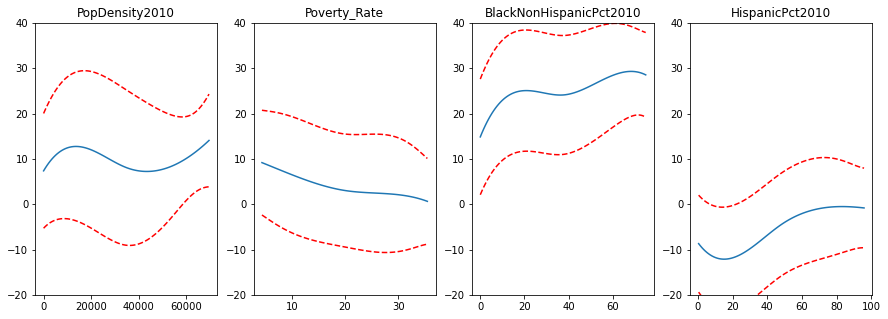

In [90]:
plt.figure();
fig, axs = plt.subplots(1,4,figsize=(15,5));
titles = ['PopDensity2010', 'Poverty_Rate', 'BlackNonHispanicPct2010', 'HispanicPct2010']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i] + X3_train[titles[i]].mean(), gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i] + X3_train[titles[i]].mean(), 
            gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_ylim(-20,40)
    ax.set_title(titles[i])

# 7. Ridge and Lasso

Now let's try some ridge and lasso models on our questions.

#### Re-split the training and testing data (on same random state) because we were getting an error with our values for the Ridge/Lasso and Random Forest

In [91]:
# Question 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,
                                                        test_size = 0.2,
                                                        random_state = 314, #used for reproducibility
                                                        stratify = df["State"])

# Question 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,
                                                        test_size = 0.2,
                                                        random_state = 314,
                                                        stratify = df["State"])

# Question 3
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3,
                                                        test_size = 0.2,
                                                        random_state = 314,
                                                        stratify = df["State"])

We are dropping `Ozone` for these models as it improves the Ridge and Lasso models because it is highly correlated with`PM2.5`. 

In [92]:
X2_rl_train = X2_train.drop("Ozone", axis =1)
X2_rl_test = X2_test.drop("Ozone", axis =1)
X1_rl_train = X1_train.drop("Ozone", axis =1)
X1_rl_test = X1_test.drop("Ozone", axis =1)

#### Question 1

Min error:  57.86261006918956
Best alpha:  [0.41246264]


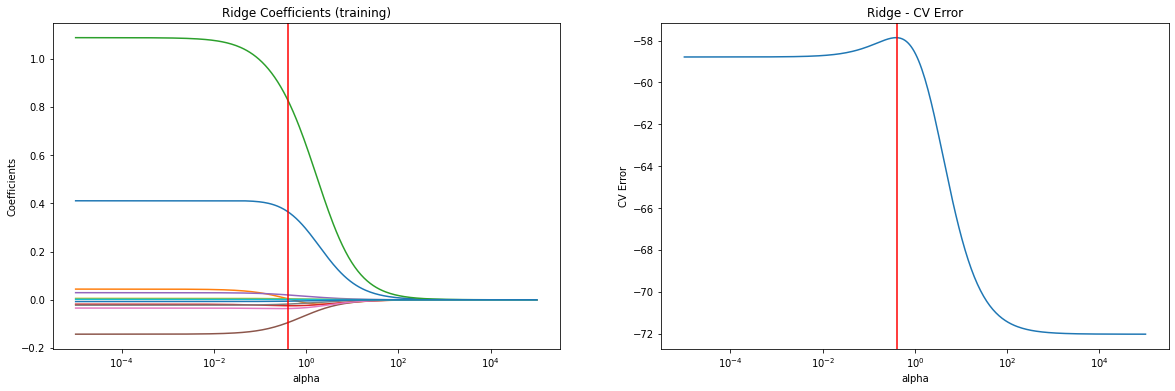

In [93]:
model_ridge1 = Ridge(normalize=True) #create Ridge object
errors1= [] #create list to append errors to
coefs_ridge1 = [] #create list of append coefficients to

alphas = np.logspace(-5, 5, 300) #set potential alphas
for a in alphas: #create for loop to loop through potential alphas
    model_ridge1.set_params(alpha=a)
    model_ridge1.fit(X1_rl_train, y1_train) #fit model
    CV_error1 = np.mean(cross_val_score(model_ridge1, X1_rl_train, y1_train, cv=10, scoring='neg_mean_squared_error')) #obtain mean of cv error
    coefs_ridge1.append(model_ridge1.coef_) #append coefficients to list
    errors1.append(CV_error1) #append cv error to list

error1 = np.abs(errors1) 
ridge_min1 = np.min(error1) #obtain and print min error
print("Min error: ", ridge_min1)
index_min1 = (np.where(error1 == np.min(error1))[0])+1
print("Best alpha: ", alphas[index_min1]) #obtain and print best alpha

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs_ridge1)
plt.axvline(x=alphas[index_min1], color = 'r') #print vertical line of best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors1)
plt.axvline(x=alphas[index_min1], color = 'r') #print vertical line of best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Ridge - CV Error')
plt.axis('tight')

plt.show() #show plots

Min error:  56.99414001429892
Best alpha:  [0.41246264]


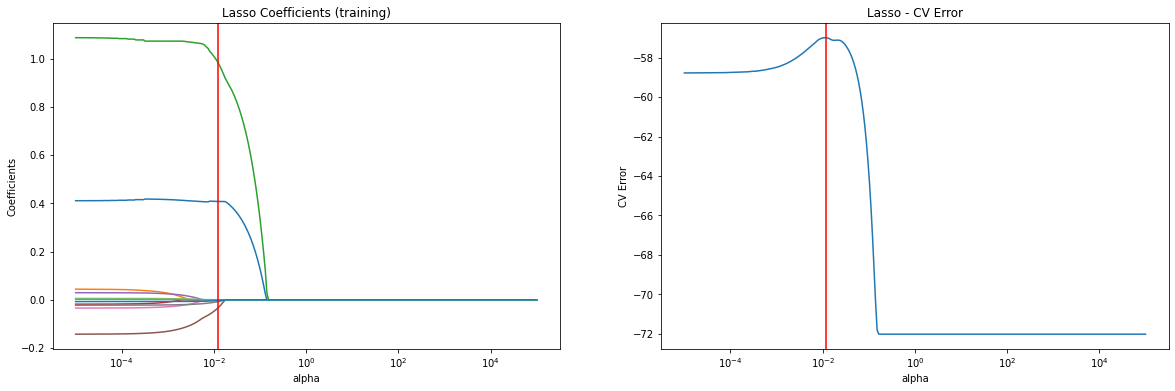

In [94]:
model_lasso1 = Lasso(normalize=True, tol = 1e-2) #create lasso object, tolerance changed so model gives same results but without warnings
errors_1= [] #create list to append errors to
coefs_lasso1 = [] #create list to append coefficients to

alphas = np.logspace(-5, 5, 300)
for a in alphas: #for loop to determine best alpha
    model_lasso1.set_params(alpha=a)
    model_lasso1.fit(X1_rl_train, y1_train) #fit model
    CV_error_1 = np.mean(cross_val_score(model_lasso1, X1_rl_train, y1_train, cv=10, scoring='neg_mean_squared_error'))
    coefs_lasso1.append(model_lasso1.coef_) #append coefficients
    errors_1.append(CV_error_1) #append mean of cv error

error_1 = np.abs(errors_1)
lasso_min1 = np.min(error_1)
print("Min error: ", lasso_min1) #determine smallest error
index_min_1 = (np.where(error_1 == np.min(error_1))[0])+1
print("Best alpha: ", alphas[index_min1]) #determine alpha value of smallest error

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs_lasso1)
plt.axvline(x=alphas[index_min_1], color = 'r') #graph vertical line of best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors_1)
plt.axvline(x=alphas[index_min_1], color = 'r') #graph vertical line of best alphas
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Lasso - CV Error')
plt.axis('tight')

plt.show() #show plots

In [95]:
print("Train MSE for Ridge Regression: ",ridge_min1) #print MSE to determine best model
print("Train MSE for Lasso Regression: ",lasso_min1)

Train MSE for Ridge Regression:  57.86261006918956
Train MSE for Lasso Regression:  56.99414001429892


Therefore, Lasso Regression has the lowest MSE and is the best model. 

In [96]:
model_lasso_final = Lasso(normalize=True, tol = 1e-2, alpha=alphas[index_min_1]) #create object with final parameters
model_lasso_final.fit(X1_rl_train, y1_train) #fit model
pred_train_lasso1 = model_lasso_final.predict(X1_rl_train) #predict
pred_test_lasso1 = model_lasso_final.predict(X1_rl_test)
print("Train R-squared: ", model_lasso_final.score(X1_rl_train,y1_train)) #print train and test R-Squared
print("Test R-Squared: ", model_lasso_final.score(X1_rl_test, y1_test))
print("Training MSE:       ", mean_squared_error(y1_train, pred_train_lasso1).round(3)) #print train and test MSE
print("Testing MSE:        ", mean_squared_error(y1_test, pred_test_lasso1).round(3))

pd.set_option('display.float_format', lambda x: '%.6f' % x) #set all float values in dataframe to standard form (not scientific notation) for easier comparison
model3_vars = pd.concat([pd.Series(X1_rl_train.columns), pd.Series(model_lasso_final.coef_),pd.Series(stats.coef_pval(model_lasso_final, X1_rl_train, y1_train)[1:])], axis = 1) #join features, coefficients and p-values into dataframe
model3_vars.rename(columns={0: "Features", 1: "Coefficients", 2:"P-values"}) #rename columns appropriately

Train R-squared:  0.22794918065260583
Test R-Squared:  0.39004948590807864
Training MSE:        55.452
Testing MSE:         39.87


,Features,Coefficients,P-values
0,Obesity,0.407991,0.000000
1,Alcohol,0.000000,1.000000
2,Diabetes,0.987211,0.000005
3,Age65AndOlderPct2010,-0.000000,1.000000
4,Median_AQI,0.000000,1.000000
5,Unhealthy_days,-0.035285,0.639691
6,CO,-0.000000,1.000000
7,NO2,-0.008108,0.560840
8,SO2,0.000000,1.000000
9,PM2.5,0.000022,0.989966


#### Question 2

Min error:  108.73307832620421
Best alpha:  [0.02578524]


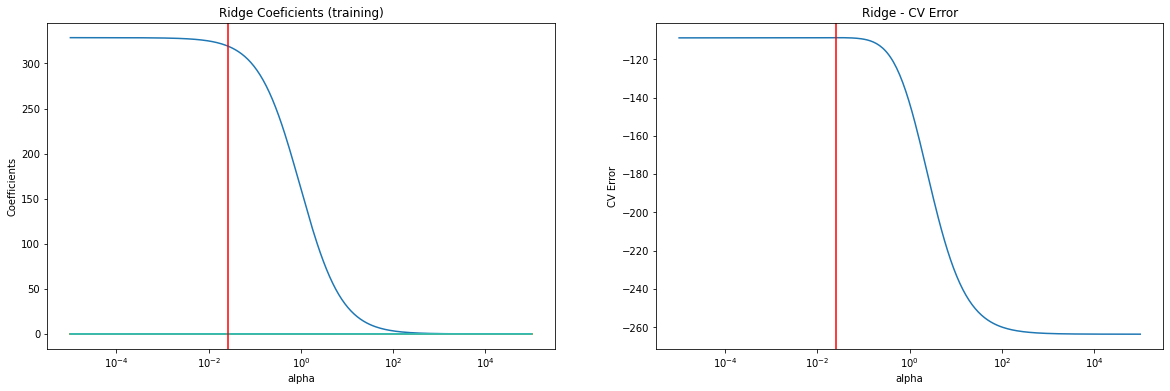

In [97]:
model_ridge2 = Ridge(normalize=True) #create ridge object
errors2= [] #create list to append errors to
coefs2 = [] #create list to append coefficients to

alphas = np.logspace(-5, 5, 300)
for a in alphas: #loop through potential alphas
    model_ridge2.set_params(alpha=a)
    model_ridge2.fit(X2_rl_train, y2_train) #fit model
    CV_error2 = np.mean(cross_val_score(model_ridge2, X2_rl_train, y2_train, cv=10, scoring='neg_mean_squared_error'))
    coefs2.append(model_ridge2.coef_) #append coefficients to list
    errors2.append(CV_error2) #append mean cv error to list

error2 = np.abs(errors2)
ridge_min2 = np.min(error2)
print("Min error: ", ridge_min2) #print minimum cv error
index_min2 = (np.where(error2 == np.min(error2))[0])+1
print("Best alpha: ", alphas[index_min2]) #print alpha value for min cv error

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs2)
plt.axvline(x=alphas[index_min2], color = 'r') #graph vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coeficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors2)
plt.axvline(x=alphas[index_min2], color = 'r') #graph vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Ridge - CV Error')
plt.axis('tight')

plt.show() #show plots

Min error:  107.48972194733138
Best alpha:  [0.00752063]


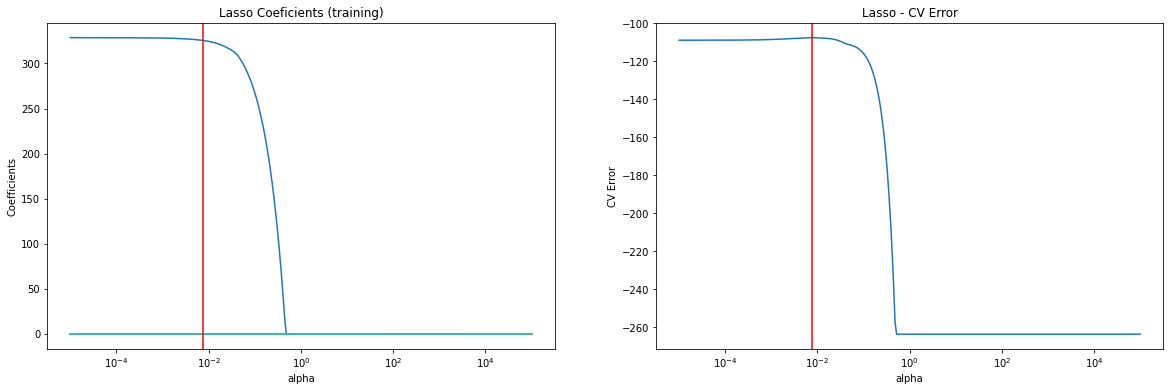

In [98]:
model_lasso2 = Lasso(normalize=True, tol = 1e-2) #create lasso object, tolerance changed so model gives same results but without warnings
errors_2= [] #create list to append errors to
coefs_2 = [] #create list to append coefficients to

alphas = np.logspace(-5, 5, 300)
for a in alphas: #loop through and test alphas
    model_lasso2.set_params(alpha=a)
    model_lasso2.fit(X2_rl_train, y2_train) #fit model
    CV_error_2 = np.mean(cross_val_score(model_lasso2, X2_rl_train, y2_train, cv=10, scoring='neg_mean_squared_error'))
    coefs_2.append(model_lasso2.coef_) #append coefficients to list
    errors_2.append(CV_error_2) #append mean cv error to list

error_2 = np.abs(errors_2)
lasso_min2 = np.min(error_2)
print("Min error: ", lasso_min2) #print min cv error
index_min_2 = (np.where(error_2 == np.min(error_2))[0])+1
print("Best alpha: ", alphas[index_min_2]) #print alpha associated with min cv error

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs_2)
plt.axvline(x=alphas[index_min_2], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
#ax.set_yscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coeficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors_2)
plt.axvline(x=alphas[index_min_2], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Lasso - CV Error')
plt.axis('tight')

plt.show() #show plots

In [99]:
print("MSE for Ridge Regression: ",ridge_min2) #print MSE for both Ridge and Lasso models to determine best model
print("MSE for Lasso Regression: ",lasso_min2)

MSE for Ridge Regression:  108.73307832620421
MSE for Lasso Regression:  107.48972194733138


Lasso has lowest MSE so it's the best model

In [100]:
model_lasso_final2 = Lasso(normalize=True, tol = 1e-2, alpha=alphas[index_min_2]) #create best model with all parameters
model_lasso_final2.fit(X2_rl_train, y2_train) #fit model
pred_train_lasso2 = model_lasso_final2.predict(X2_rl_train) #predict
pred_test_lasso2 = model_lasso_final2.predict(X2_rl_test)
print("Train R-squared: ", model_lasso_final2.score(X2_rl_train,y2_train)) #print train and test R-squared
print("Test R-Squared: ", model_lasso_final2.score(X2_rl_test, y2_test))
print("Training MSE:       ", mean_squared_error(y2_train, pred_train_lasso2).round(3)) #print train and test MSE
print("Testing MSE:        ", mean_squared_error(y2_test, pred_test_lasso2).round(3))

pd.set_option('display.float_format', lambda x: '%.6f' % x) #set all float values in dataframe to standard form (not scientific notation) for easier comparison
model3_vars = pd.concat([pd.Series(X2_rl_train.columns), pd.Series(model_lasso_final2.coef_),pd.Series(stats.coef_pval(model_lasso_final2, X2_rl_train, y2_train)[1:])], axis = 1) #concatenate features, coefficients and p-values together in 1 dataframe
model3_vars.rename(columns={0: "Features", 1: "Coefficients", 2:"P-values"}) #rename columns

Train R-squared:  0.6011322167973749
Test R-Squared:  0.6576014467978757
Training MSE:        104.775
Testing MSE:         81.787


,Features,Coefficients,P-values
0,Smoking,325.501565,0.000000
1,Asbestos,-0.022612,0.028487
2,averageRadonLevel,-0.000000,1.000000
3,Median_AQI,0.000000,1.000000
4,Unhealthy_days,-0.177598,0.076985
5,CO,0.043740,0.674363
6,NO2,-0.009042,0.636817
7,SO2,-0.000000,1.000000
8,PM2.5,-0.002024,0.394368
9,PM10,-0.026475,0.000248


#### Question 3

Min error:  114.03072866128896
Best alpha:  [0.25984581]


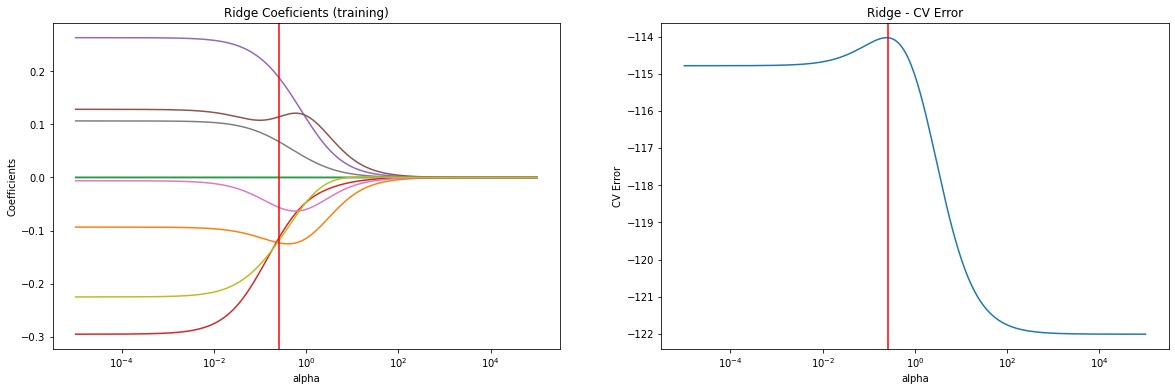

In [101]:
model_ridge3 = Ridge(normalize=True) #create Ridge object
errors3= [] #create list to append errors to
coefs3 = [] #create list to append coefficients to

alphas = np.logspace(-5, 5, 300)
for a in alphas: #for loop to determine best alpha
    model_ridge3.set_params(alpha=a)
    model_ridge3.fit(X3_train, y3_train) #fit model
    CV_error3 = np.mean(cross_val_score(model_ridge3, X3_train, y3_train, cv=10, scoring='neg_mean_squared_error'))
    coefs3.append(model_ridge3.coef_) #append coefficients to list
    errors3.append(CV_error3) #append mean cv error to list

error3 = np.abs(errors3)
ridge_min3 = np.min(error3)
print("Min error: ", ridge_min3) #print min cv error
index_min3 = (np.where(error3 == np.min(error3))[0])+1
print("Best alpha: ", alphas[index_min3]) #print alpha associated with min cv error

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs3)
plt.axvline(x=alphas[index_min3], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coeficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors3)
plt.axvline(x=alphas[index_min3], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Ridge - CV Error')
plt.axis('tight')

plt.show() #show plots

Min error:  113.81404778698592
Best alpha:  [0.00877291]


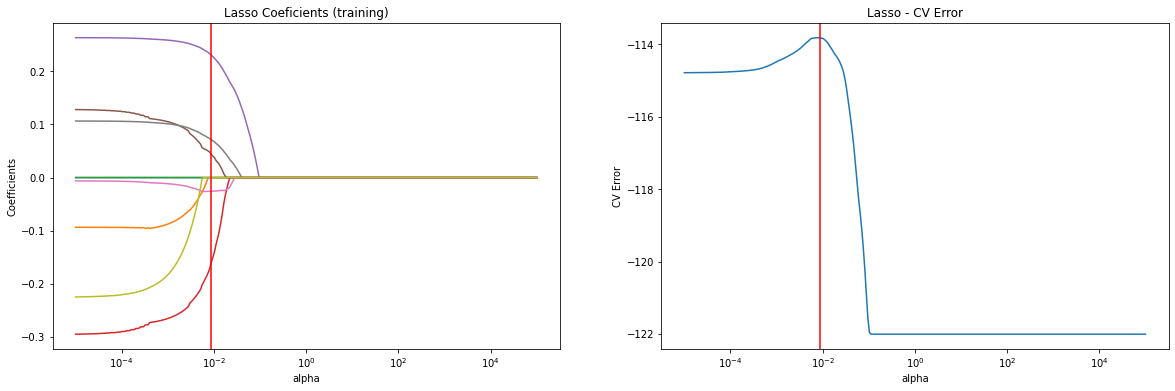

In [102]:
model_lasso3 = Lasso(normalize=True, tol = 1e-2) #create lasso object, tolerance changed so model gives same results but without warnings
errors_3= [] #create list to append errors to
coefs_3 = [] #create list to append coefficients to

alphas = np.logspace(-5, 5, 300)
for a in alphas: #loop through to find best alpha
    model_lasso3.set_params(alpha=a)
    model_lasso3.fit(X3_train, y3_train) #fit model
    CV_error_3 = np.mean(cross_val_score(model_lasso3, X3_train, y3_train, cv=10, scoring='neg_mean_squared_error'))
    coefs_3.append(model_lasso3.coef_) #append coefficients to list
    errors_3.append(CV_error_3) #append mean cv error to list

error_3 = np.abs(errors_3)
lasso_min3 = np.min(error_3)
print("Min error: ", lasso_min3) #print min cv error
index_min_3 = (np.where(error_3 == np.min(error_3))[0])+1
print("Best alpha: ", alphas[index_min_3]) #print alpha associated with min cv error

plt.figure(figsize=(20, 6))

plt.subplot(121) #plot coefficients vs alphas
ax = plt.gca()
ax.plot(alphas, coefs_3)
plt.axvline(x=alphas[index_min_3], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coeficients (training)')
plt.axis('tight')

plt.subplot(122) #plot cv error vs alphas
ax = plt.gca()
ax.plot(alphas, errors_3)
plt.axvline(x=alphas[index_min_3], color = 'r') #vertical line showing best alpha
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('CV Error')
plt.title('Lasso - CV Error')
plt.axis('tight')

plt.show() #show plots

In [103]:
print("MSE for Ridge Regression: ",ridge_min3) #print Ridge and Lasso MSE values to pick best model
print("MSE for Lasso Regression: ",lasso_min3)

MSE for Ridge Regression:  114.03072866128896
MSE for Lasso Regression:  113.81404778698592


Lasso has the lowest MSE (but not by much) meaning it is the better model.

In [104]:
model_lasso_final3 = Lasso(normalize=True, tol = 1e-2, alpha=alphas[index_min_3]) #create object of best model
model_lasso_final3.fit(X3_train, y3_train) #fit
pred_train_lasso3 = model_lasso_final3.predict(X3_train) #predict
pred_test_lasso3 = model_lasso_final3.predict(X3_test)
print("Train R-squared: ", model_lasso_final3.score(X3_train,y3_train)) #print train and test R-squared
print("Test R-Squared: ", model_lasso_final3.score(X3_test, y3_test))
print("Training MSE:       ", mean_squared_error(y3_train, pred_train_lasso3).round(3)) #print train and test MSE
print("Testing MSE:        ", mean_squared_error(y3_test, pred_test_lasso3).round(3))

pd.set_option('display.float_format', lambda x: '%.6f' % x) #set all float values in dataframe to standard form (not scientific notation) for easier comparison
model3_vars = pd.concat([pd.Series(X3_train.columns), pd.Series(model_lasso_final3.coef_),pd.Series(stats.coef_pval(model_lasso_final3, X3_train, y3_train)[1:])], axis = 1) #concatenate features, coefficients and p-values in one dataframe
model3_vars.rename(columns={0: "Features", 1: "Coefficients", 2:"P-values"}) #rename columns

Train R-squared:  0.08921355799754194
Test R-Squared:  0.11221544768165526
Training MSE:        110.563
Testing MSE:         116.336


,Features,Coefficients,P-values
0,Median_Income,0.000041,0.000000
1,UnempRate2019,-0.000000,1.000000
2,PopDensity2010,0.000043,0.714102
3,Poverty_Rate,-0.159006,0.026875
4,BlackNonHispanicPct2010,0.230087,0.000000
5,AsianNonHispanicPct2010,0.043040,0.789787
6,NativeAmericanNonHispanicPct2010,-0.025816,0.726610
7,HispanicPct2010,0.071152,0.022422
8,MultipleRacePct2010,-0.000000,1.000000


# 8. Random Forest Regressor

### Question 1

In [105]:
# Fit random forest
rf = RandomForestRegressor(max_depth = 30, random_state=1) # try max depth of 30 for now and will be tuned later
rf.fit(X1_train, y1_train)

# Metrics for comparison to other models
print("R-Squared Train: ", round(rf.score(X1_train, y1_train), 3))
print('Training MSE: ', mean_squared_error(y1_train, rf.predict(X1_train)).round(3))
print("R-Squared Test: ", round(rf.score(X1_test, y1_test), 3))
print('Testing MSE: ', mean_squared_error(y1_test, rf.predict(X1_test)).round(3))

R-Squared Train:  0.896
Training MSE:  7.479
R-Squared Test:  0.37
Testing MSE:  41.178


#### Tune n_estimators using a CV loop

In [106]:
avg_errors = []
numbers1 = [25, 50, 100, 150, 200, 300, 400, 500] # tune the number of estimators

for i in numbers1: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = 30, n_estimators = i) # tune max depth later
    cv_score = cross_val_score(rf_loop, X1_train, y1_train, cv = 10, scoring='neg_mean_squared_error') # MSE
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    avg_errors.append(cv_average)

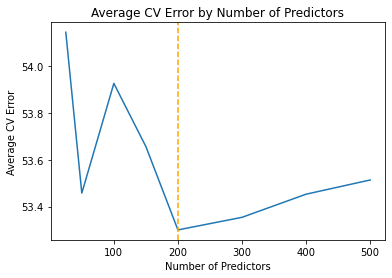

In [107]:
linear_min_error = min(avg_errors) # select the lowest average error

plt.plot(numbers1, avg_errors)
plt.axvline(numbers1[avg_errors.index(linear_min_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

In [108]:
# Tune the model according to our minimum value from the above loop (200)
rf1_tuned = RandomForestRegressor(max_depth=30, random_state=1, n_estimators = 200)
rf1_tuned.fit(X1_train, y1_train)
rf1_pred = rf1_tuned.predict(X1_test)

# Metrics for comparison 
print("R-Squared Train: ", round(rf1_tuned.score(X1_train, y1_train), 3))
print('Training MSE: ', mean_squared_error(y1_train, rf1_tuned.predict(X1_train)))
print("R-Squared Test: ", round(rf1_tuned.score(X1_test, y1_test), 3))
print('Testing MSE: ', mean_squared_error(y1_test, rf1_tuned.predict(X1_test)))

R-Squared Train:  0.897
Training MSE:  7.407873348150758
R-Squared Test:  0.376
Testing MSE:  40.811764963068164


#### Tune max_depth using a CV loop

In [109]:
# Tune max_depth because we arbitrarily selected 30 earlier
depth_errors = []
depths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i in depths: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = i, n_estimators = 200)
    cv_score = cross_val_score(rf_loop, X1_train, y1_train, cv = 10, scoring='neg_mean_squared_error') # MSE
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    depth_errors.append(cv_average)

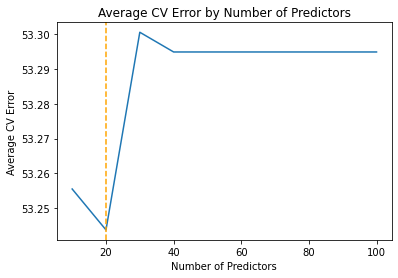

In [110]:
min_depth_error = min(depth_errors) # select the minimum error 

plt.plot(depths, depth_errors)
plt.axvline(depths[depth_errors.index(min_depth_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

In [111]:
# Refit our model with our new metrics
rf1_tuned = RandomForestRegressor(max_depth=20, random_state=1, n_estimators = 200)
rf1_tuned.fit(X1_train, y1_train)

print("R-Squared Train: ", round(rf1_tuned.score(X1_train, y1_train), 3))
print('Training MSE: ', mean_squared_error(y1_train, rf1_tuned.predict(X1_train)))
print("R-Squared Test: ", round(rf1_tuned.score(X1_test, y1_test), 3))
print('Testing MSE: ', mean_squared_error(y1_test, rf1_tuned.predict(X1_test)))

R-Squared Train:  0.897
Training MSE:  7.412901645012168
R-Squared Test:  0.381
Testing MSE:  40.45996638509642


#### Plot the importances from the best performing model

Text(0.5, 0, 'Features')

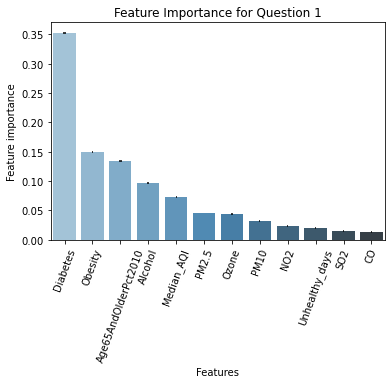

In [112]:
importances = rf1_tuned.feature_importances_
forest_importances = pd.Series(importances)
std = np.std([tree.feature_importances_ for tree in rf1_tuned.estimators_], axis=0)

forest_importances1 = pd.DataFrame({'features': X1.columns, 'importances': rf1_tuned.feature_importances_})

sns.barplot(x="features",y="importances" ,data=forest_importances1, 
            order=forest_importances1.sort_values('importances',ascending = False).features, palette="Blues_d", 
           xerr = std)

plt.xticks(rotation=70)
plt.title("Feature Importance for Question 1")
plt.ylabel("Feature importance")
plt.xlabel("Features")

### Question 2

In [113]:
# fit the initial model
rf2 = RandomForestRegressor(max_depth=30, random_state=1) # select max_depth = 30 for now, but we will tune this later
rf2.fit(X2_train, y2_train)

print("R-Squared Train: ", round(rf2.score(X2_train, y2_train), 3))
print('Training MSE: ', mean_squared_error(y2_train, rf2.predict(X2_train)))
print("R-Squared Test: ", round(rf2.score(X2_test, y2_test), 3))
print('Testing MSE: ', mean_squared_error(y2_test, rf2.predict(X2_test)))

R-Squared Train:  0.948
Training MSE:  13.753437970127994
R-Squared Test:  0.61
Testing MSE:  93.09449600000016


#### Tune the number of estimators using a CV loop

In [114]:
avg_errors = []
numbers = [1, 50, 100, 150, 200, 300, 400, 500]

for i in numbers: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = 30, n_estimators = i)
    cv_score = cross_val_score(rf_loop, X2_train, y2_train, cv = 10, scoring='neg_mean_squared_error')
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    avg_errors.append(cv_average)

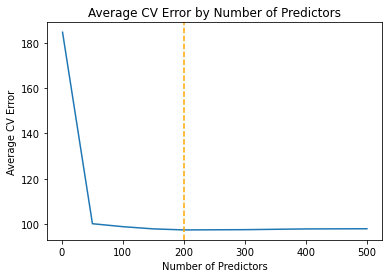

In [115]:
linear_min_error = min(avg_errors) # find minimum error

plt.plot(numbers, avg_errors)
plt.axvline(numbers[avg_errors.index(linear_min_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

In [116]:
# refit model to the n_estimators of 200
rf2_tuned = RandomForestRegressor(max_depth=30, random_state=1, n_estimators = 200)
rf2_tuned.fit(X2_train, y2_train)
rf2_pred = rf2_tuned.predict(X2_test)

# Metrics for model comparison
print("R-Squared Train: ", round(rf2_tuned.score(X2_train, y2_train), 3))
print('Training MSE: ', mean_squared_error(y2_train, rf2_tuned.predict(X2_train)))
print("R-Squared Test: ", round(rf2_tuned.score(X2_test, y2_test), 3))
print('Testing MSE: ', mean_squared_error(y2_test, rf2_tuned.predict(X2_test)))

R-Squared Train:  0.948
Training MSE:  13.679474965860582
R-Squared Test:  0.616
Testing MSE:  91.71625276704542


#### Use grid search to cross-validate the max_depth and the max_leaf_nodes

In [117]:
# Try Grid Search for max_depth and max_leaf_nodes
print(rf2_tuned.get_params().keys()) # figure out which parameters can be tuned

# create dictionary with 3 parameters to tune (values are arbitrary)
dictionary = {"max_depth" : [10, 25, 50], 
              "max_leaf_nodes" : [10, 25, 50]}

rf2_tuned2 = RandomForestRegressor(random_state = 1, n_estimators = 200)
rf2_tuned2.fit(X2_train, y2_train)

GS = GridSearchCV(estimator = rf2_tuned2, 
                  param_grid = dictionary, 
                  scoring = ["r2", "neg_mean_squared_error"],
                  refit = "r2", 
                  cv = 5, 
                  verbose = 4)

GS.fit(X2_train, y2_train)
print()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=10, max_leaf_nodes=10; neg_mean_squared_error: (test=-142.549) r2: (test=0.529) total time=   0.2s
[CV 2/5] END max_depth=10, max_leaf_nodes=10; neg_mean_squared_error: (test=-81.296) r2: (test=0.594) total time=   0.2s
[CV 3/5] END max_depth=10, max_leaf_nodes=10; neg_mean_squared_error: (test=-92.282) r2: (test=0.606) total time=   0.2s
[CV 4/5] END max_depth=10, max_leaf_nodes=10; neg_mean_squared_error: (test=-98.413) r2: (test=0.622) total time=   0.2s
[CV 5/5] END max_depth=10, max_leaf_nodes=10; neg_mean_squared_error: (test=-120.341) r2: (test=0.601) total time=   0.2s
[CV 1/5] END max_depth=1

In [118]:
print(GS.best_params_)

# Tune the model based on the best parameters from the grid search
rf2_tuned3 = RandomForestRegressor(max_depth=10, random_state=1, n_estimators = 200, max_leaf_nodes = 50)
rf2_tuned3.fit(X2_train, y2_train)

# Metrics for model comparison
print("R-Squared Train: ", round(rf2_tuned3.score(X2_train, y2_train), 3))
print('Training MSE: ', mean_squared_error(y2_train, rf2_tuned3.predict(X2_train)))
print("R-Squared Test: ", round(rf2_tuned3.score(X2_test, y2_test), 3))
print('Testing MSE: ', mean_squared_error(y2_test, rf2_tuned3.predict(X2_test)))

{'max_depth': 10, 'max_leaf_nodes': 50}
R-Squared Train:  0.83
Training MSE:  44.71386592952715
R-Squared Test:  0.631
Testing MSE:  88.13654041386543


In [119]:
# tune max_depth using a for loop to double check the max_depth tune. 
depth_errors = []
depths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i in depths: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = i, n_estimators = 200)
    cv_score = cross_val_score(rf_loop, X2_train, y2_train, cv = 10, scoring='neg_mean_squared_error')
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    depth_errors.append(cv_average)

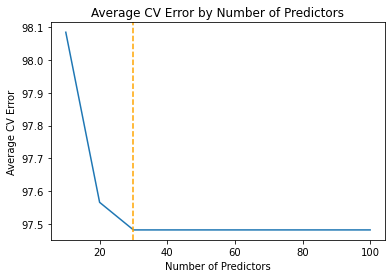

In [120]:
min_depth_error = min(depth_errors) # select the lowest error

plt.plot(depths, depth_errors)
plt.axvline(depths[depth_errors.index(min_depth_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

#### Plot the importances for the best performed model 

Text(0.5, 0, 'Features')

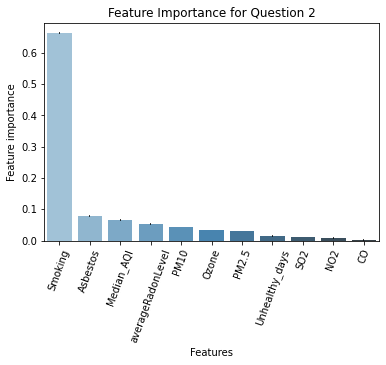

In [121]:
importances = rf2_tuned2.feature_importances_
forest_importances2 = pd.Series(importances)
std2 = np.std([tree.feature_importances_ for tree in rf2_tuned2.estimators_], axis=0)

forest_importances2 = pd.DataFrame({'features': X2.columns, 'importances': rf2_tuned2.feature_importances_})

sns.barplot(x="features",y="importances" ,data=forest_importances2, 
            order=forest_importances2.sort_values('importances',ascending = False).features, palette="Blues_d", 
           xerr = std2)
plt.xticks(rotation=70)
plt.title("Feature Importance for Question 2")
plt.ylabel("Feature importance")
plt.xlabel("Features")

### Question 3

In [122]:
# Fit model to data
rf3 = RandomForestRegressor(max_depth=30, random_state=1)
rf3.fit(X3_train, y3_train)
rf3_pred = rf3.predict(X3_test)

# Metrics for model comparison
print("R-Squared Train: ", round(rf3.score(X3_train, y3_train), 3))
print('Training MSE: ', mean_squared_error(y3_train, rf3.predict(X3_train)))
print("R-Squared Test: ", round(rf3.score(X3_test, y3_test), 3))
print('Testing MSE: ', mean_squared_error(y3_test, rf3.predict(X3_test)))

R-Squared Train:  0.886
Training MSE:  13.848189758179231
R-Squared Test:  0.171
Testing MSE:  108.60062386363634


#### Tune the number of estimators using a CV loop

In [123]:
avg_errors = []
numbers = [25, 50, 100, 150, 200, 300, 400, 500] # tune the number of estimators

for i in numbers: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = 30, n_estimators = i)
    cv_score = cross_val_score(rf_loop, X3_train, y3_train, cv = 10, scoring='neg_mean_squared_error')
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    avg_errors.append(cv_average)

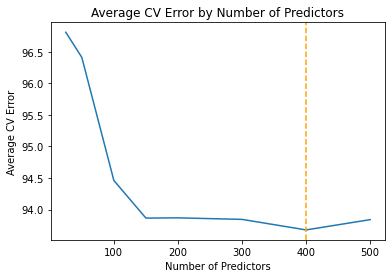

In [124]:
linear_min_error = min(avg_errors) # select the number lowest error

plt.plot(numbers, avg_errors)
plt.axvline(numbers[avg_errors.index(linear_min_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

In [125]:
# Refit the model with 400 n_estimators
rf3 = RandomForestRegressor(max_depth=30, random_state=1, n_estimators = 400)
rf3.fit(X3_train, y3_train)
rf3_pred = rf3.predict(X3_test)

# Metrics for model validation
print("R-Squared Train: ", round(rf3.score(X3_train, y3_train), 3))
print('Training MSE: ', mean_squared_error(y3_train, rf3.predict(X3_train)))
print("R-Squared Test: ", round(rf3.score(X3_test, y3_test), 3))
print('Testing MSE: ', mean_squared_error(y3_test, rf3.predict(X3_test)))

R-Squared Train:  0.891
Training MSE:  13.187781392247508
R-Squared Test:  0.17
Testing MSE:  108.82190827414773


#### Tune the max_depth using a CV loop

In [126]:
depth_errors = []
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # tune depths (different values since previous numbers gave an optimal depth of 10, so we decided go lower)

for i in depths: 
    rf_loop = RandomForestRegressor(random_state = 1, max_depth = i, n_estimators = 400)
    cv_score = cross_val_score(rf_loop, X3_train, y3_train, cv = 10, scoring='neg_mean_squared_error')
    cv_average = cv_score.mean() * -1 # convert from negative to positive
    depth_errors.append(cv_average)

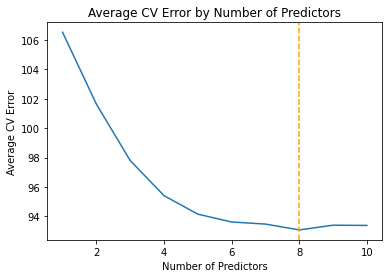

In [127]:
min_depth_error = min(depth_errors) # select lowest error value

plt.plot(depths, depth_errors)
plt.axvline(depths[depth_errors.index(min_depth_error)], color = "orange", linestyle = '--') # plot vertical line at minimum error
plt.title("Average CV Error by Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Average CV Error")
plt.axis("tight")
plt.show()

In [128]:
# Refit model for max_depth of 8
rf3 = RandomForestRegressor(max_depth=8, random_state=1, n_estimators = 400)
rf3.fit(X3_train, y3_train)
rf3_pred = rf3.predict(X3_test)

print("R-Squared Train: ", round(rf3.score(X3_train, y3_train), 3))
print('Training MSE: ', mean_squared_error(y3_train, rf3.predict(X3_train)))
print("R-Squared Test: ", round(rf3.score(X3_test, y3_test), 3))
print('Testing MSE: ', mean_squared_error(y3_test, rf3.predict(X3_test)))

R-Squared Train:  0.736
Training MSE:  32.019179181240695
R-Squared Test:  0.181
Testing MSE:  107.27345030014608


#### Use grid search to tune the max_leaf_nodes and the min_samples split

In [129]:
# Try Grid Search for max_depth and max_leaf_nodes
print(rf3.get_params().keys()) # figure out which parameters can be tuned

# create dictionary with 3 parameters to tune (values are arbitrary)
dictionary = { "max_leaf_nodes" : [10, 20, 30, 40, 50],
             "min_samples_split": [2, 5, 10]}

GS = GridSearchCV(estimator = rf3, 
                  param_grid = dictionary, 
                  scoring = ["r2", "neg_mean_squared_error"],
                  refit = "r2", 
                  cv = 5, 
                  verbose = 4)

GS.fit(X3_train, y3_train)
 

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END max_leaf_nodes=10, min_samples_split=2; neg_mean_squared_error: (test=-93.909) r2: (test=0.044) total time=   0.6s
[CV 2/5] END max_leaf_nodes=10, min_samples_split=2; neg_mean_squared_error: (test=-81.939) r2: (test=0.292) total time=   0.6s
[CV 3/5] END max_leaf_nodes=10, min_samples_split=2; neg_mean_squared_error: (test=-79.847) r2: (test=0.268) total time=   0.6s
[CV 4/5] END max_leaf_nodes=10, min_samples_split=2; neg_mean_squared_error: (test=-139.435) r2: (test=0.188) total time=   0.6s
[CV 5/5] END max_leaf_nodes=10, min_samples_split=2; neg_mean_squared_error: (test=-94.491) r2: (test=0.155) total ti

[CV 2/5] END max_leaf_nodes=50, min_samples_split=2; neg_mean_squared_error: (test=-74.945) r2: (test=0.352) total time=   0.8s
[CV 3/5] END max_leaf_nodes=50, min_samples_split=2; neg_mean_squared_error: (test=-76.853) r2: (test=0.296) total time=   1.1s
[CV 4/5] END max_leaf_nodes=50, min_samples_split=2; neg_mean_squared_error: (test=-130.344) r2: (test=0.241) total time=   0.9s
[CV 5/5] END max_leaf_nodes=50, min_samples_split=2; neg_mean_squared_error: (test=-100.301) r2: (test=0.103) total time=   0.9s
[CV 1/5] END max_leaf_nodes=50, min_samples_split=5; neg_mean_squared_error: (test=-95.044) r2: (test=0.032) total time=   0.9s
[CV 2/5] END max_leaf_nodes=50, min_samples_split=5; neg_mean_squared_error: (test=-75.198) r2: (test=0.350) total time=   0.8s
[CV 3/5] END max_leaf_nodes=50, min_samples_split=5; neg_mean_squared_error: (test=-77.119) r2: (test=0.293) total time=   0.9s
[CV 4/5] END max_leaf_nodes=50, min_samples_split=5; neg_mean_squared_error: (test=-131.189) r2: (test

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=8, n_estimators=400,
                                             random_state=1),
             param_grid={'max_leaf_nodes': [10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10]},
             refit='r2', scoring=['r2', 'neg_mean_squared_error'], verbose=4)

In [130]:
print(GS.best_params_)

# Refit model for max_depth of 8
rf3_tuned = RandomForestRegressor(max_depth=8, random_state=1, n_estimators = 400, max_leaf_nodes = 40, min_samples_split = 5)
rf3_tuned .fit(X3_train, y3_train)

print("R-Squared Train: ", round(rf3_tuned.score(X3_train, y3_train), 3))
print('Training MSE: ', mean_squared_error(y3_train, rf3_tuned.predict(X3_train)))
print("R-Squared Test: ", round(rf3_tuned.score(X3_test, y3_test), 3))
print('Testing MSE: ', mean_squared_error(y3_test, rf3_tuned.predict(X3_test)))

{'max_leaf_nodes': 40, 'min_samples_split': 5}
R-Squared Train:  0.663
Training MSE:  40.881351170393465
R-Squared Test:  0.182
Testing MSE:  107.24884935507676


#### Plot the importances for the best performing model

Text(0.5, 0, 'Features')

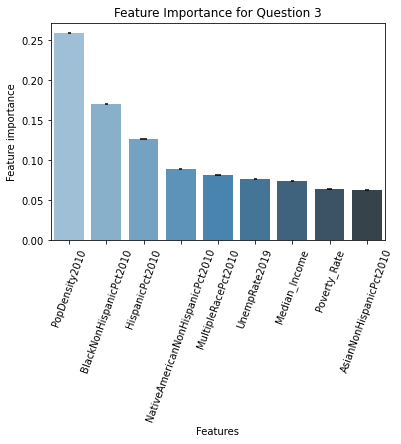

In [131]:
importances = rf3_tuned.feature_importances_
forest_importances3 = pd.Series(importances)
std3 = np.std([tree.feature_importances_ for tree in rf3_tuned.estimators_], axis=0)

forest_importances3 = pd.DataFrame({'features': X3.columns, 'importances': rf3_tuned.feature_importances_})

sns.barplot(x="features",y="importances" ,data=forest_importances3, 
            order=forest_importances3.sort_values('importances', ascending = False).features, palette="Blues_d", xerr = std3)
plt.xticks(rotation=70)
plt.title("Feature Importance for Question 3")
plt.ylabel("Feature importance")
plt.xlabel("Features")

# 9. Model Selection and Conclusions

### Question 1

Complex models don't always perform better: Particularly, when running our model on our validation set, we observed that the simple linear model performed better than the more complex ridge, lasso, GAMs, and random forest regressors. We fine tuned the model with a forward stepwise feature selection algorithm. Reducing the parameters in our model further decreased our test MSE to 37.4 -- a sign that we have found the most relevant parameters and removed unnecessary ones who cause overfitting.

In our final model, we observe that the control variables Obesity and Diabetes very significantly related to the number of deaths caused by strokes. 
Furthermore, the median air quality also shows a statistically significant positive correlation with strokes. The coefficient of 0.068 means that a Median AQI increase of 15 correlated to 1 more death per 100,000 people. Its p-value is 0.014 < 0.05.

The number of unhealthy days is negatively correlated with strokes which runs contrary to our hypothesis and is therefore presumably picking up noise in our data. The predictor `SO2`, on the other hand, is positively correlated with a coefficient of 0.0057, meaning that if on 200 days per year the SO2 levels exceeded the recommended threshold, there would be a correlation with 1 more death per 100,000 people. However, the p-value of this predictor is 0.293 which exceeds our statistical significance level of 0.05.

### Question 2

Ultimately our best model for question 2 was found to be a lasso regression. We first compared Ridge and Lasso models to pick the best one and found that Lasso’s MSE of 107.49 was lower than the Ridge MSE of 108.73. As a result, we then compared lasso to linear regression, random forest, and general additive. The Random Forest model had the best Train MSE at 13.7, but also the highest test MSE of 91.7 so we decided that model was overfit. Of those remaining, the general additive model, the linear regression and lasso, all had similar train and test MSE. We chose the lasso model in the end because it had the better R-squared value (0.66) and the MSE difference between the three models is so tiny. 

Our best model for this question is the Lasso Regression. The built-in feature selection eliminated Average Radon Level, Median AQI and SO2 from the predictor variables. There were 3 statistically significant (at the 0.05 level) predictors: smoking, asbestos and PM10. Smoking, a control variable, was found to be overwhelmingly correlated with lung cancer which makes sense as smoking is the top cause of lung diseases in the United States. However, all other significant variables were found to have a negative relationship with lung cancer incidence. We suspect that smoking is affecting the other variables in this model due to how large the coefficient is and how significant it is. 

### Question 3

After comparing the 4 models for the question 3 data we decided to pick the Random Forest Regressor and the General Additive Models. We did to get interpretable models to answer our questions. These two models also had the lowest test mean squared errors for after tuning our models. The Random Forest Regressor has a test MSE of 107.27, and the General Additive Model has a test MSE of 114.2. Both are lower than the MSEs for the linear and Ridge/Lasso regressions. 

The feature importance graph for the Random Forest Model shows that Population Density is the most important factor in explaining our question. Higher population densities are correlated with counties with higher pollution. Population density is also an indicator for the degree of urbanization. These areas have higher energy usage, and thus have higher rates of direct pollution. 

The next most important features are the proportions of Black, Hispanic, and Native American populations by county. This was interesting to see because these marginalized communities have a higher likelihood of living in counties with poor air quality. Our data shows evidence of environmental injustice, as these marginalized communities face poor air quality conditions that are out of their control. This can affect their day-to-day lives as well as increase their risk for potential diseases (although our studies show that there wasn’t a strong correlation). 

Our Random Forest can point to specific features that are important in the data, but it cannot tell us much about the relationship between our dependent and independent variables. Our General Additive Model can speak to this. 

# 10. Discussions

We found that most of our control variables were significantly related to the health outcomes we investigated. This makes sense as we used medical research to inform these and indicates we chose our control variables well. Our models show that worse air quality index impacts the number of deaths due to stroke, but contrastingly we could not find a positive correlation between lung cancer and pollution. In looking at question 3 we did see that marginalized groups, especially those who are Black, Hispanic, or Native American have a higher importance in predicting median AQI. 

Overall, this process and our models have taught us a lot. We believe that pollution may play a minor role in health conditions, but more investigation is needed to determine anything wholly conclusive. We had a few models with low R-squared which helped us understand that real world data and complicated issues with lots of factors may be too chaotic for Machine Learning and that an amazing model with an R-squared of 90% or higher simply isn’t feasibly for some real-world problems. Additionally, we found that simple models like linear regression can be much more powerful than expected. They may have more bias but are less likely to overfit and generalize well to new data. 

# 11. Future Work

Our group identified various things that could be done to improve our study in the future. 

One of the first things we discussed was adjustments to our data. As we mentioned before, our data goes back to 2010. However, the impacts of air pollution on lung disease take a long time to develop. As such, we should consider air quality data for a longer timeframe (50+ years). We assume that this would also show larger differences in air quality (and other pollutants), because there is a cumulative effect to greenhouse gas emissions. However, one of the constraints of our data was that it was difficult to find a centralized location for air quality data for all counties. There is data available for counties by state, but no national database. 

The next consideration we made was the locations of the data. We decided to do a county-level analysis in the United States because the datasets were most readily available at that level. However, it would be interesting to do this analysis on a more granular scale. For example, we were thinking about doing this analysis on areas with active coal mines or oil plants. It would be interesting to do this analysis for areas that are currently producing (or historically have produced) high amounts of carbon emissions from fossil fuel extraction. These models are not place specific; therefore, they can be applied to various scenarios. 

The final thing that was discussed, were alternate models that would help us answer our inferential questions. Advanced machine learning models like Double Machine Learning or Causal Forests would help us learn more about the causal relationships between the correlations we found with our regressions. We have not learned these models in this class, but these models would be additional models well suited to help answer our questions.


# 12. References:

- `pandas.astype` function: https://sparkbyexamples.com/pandas/pandas-convert-string-to-float-type-dataframe/
- removing rows with a certain value: https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
- color palettes for plots from: http://man.hubwiz.com/docset/Seaborn.docset/Contents/Resources/Documents/tutorial/color_palettes.html
- `pandas.DataFrame.at`: https://re-thought.com/how-to-change-or-update-a-cell-value-in-python-pandas-dataframe/
- `pyGAM` Documentation: https://readthedocs.org/projects/pygam/downloads/pdf/latest/
- `tol` in ridge and lasso: https://stats.stackexchange.com/questions/445831/how-is-tol-used-in-scikit-learns-lasso-and-elasticnet
- convergence of ridge and lasso: https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge
- p-values of ridge and lasso: https://stackoverflow.com/questions/54322598/p-values-from-ridge-regression-in-python
- `regressors` Documentation: https://regressors.readthedocs.io/en/latest/usage.html
- how to supress scientific notation: https://stackoverflow.com/questions/16962512/convert-scientific-notation-to-decimal-python and https://stackoverflow.com/questions/21137150/format-suppress-scientific-notation-from-python-pandas-aggregation-results
- Hyperparameter Tuning the RF: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74